In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!python -m spacy download en_core_web_md
#%pip install --upgrade numpy gensim

## Data Loading


In [2]:
import pandas as pd
df_movies = pd.read_csv('movies_titled.csv')
display(df_movies.head())

,title,script,genres
0,Predator,\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r...,"Action,Horror,Sci-Fi,Thriller"
1,Master and Commander,\r\n\r\n\r\n\r\n MASTER AND COMMANDER: T...,"Action,Adventure,Drama"
2,White Christmas,"\r\n ""WHITE...","Comedy,Musical,Romance"
3,Fantastic Beasts: The Crimes of Grindelwald,\r\n\r\n\r\n\r\n\r\n FANTASTIC BEAS...,"Fantasy,Family,Adventure"
4,Legend,LEGEND\r\nORIGINAL SCREENPLAY by WILLIAM HJORT...,"Fantasy,Adventure,Romance"


In [ ]:
len(df_movies)

1211

#### Genre Parsing

In [3]:
import pandas as pd
import numpy as np

valid_genres = ['Sci-Fi', 'Thriller', 'Horror', 'Action', 'Comedy', 'Drama', 'Romance', 'Crime']

def parse_genres(genreString):
    if pd.isna(genreString):  # Check if it's NaN
        return np.nan
    genrelist = [genre for genre in genreString.split(',') if genre in valid_genres]
    return genrelist if genrelist else np.nan

df_movies['genres'] = df_movies['genres'].apply(parse_genres)


## spaCy preprocessing

In [ ]:
import spacy

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import re

def extract_content(script: str) -> str:
    # remove parentheticals
    script = re.sub(r'\(.*?\)', '', script)

    out_lines = []
    for line in script.splitlines():
        s = line.strip()
        if not s:
            continue

        # Remove scene heads
        if re.match(r'^(INT\.|EXT\.)', s):
            continue
        # remove transitions
        if re.match(r'^(CUT TO:|DISSOLVE TO:|FADE(IN| OUT))', s, flags=re.IGNORECASE):
            continue

        out_lines.append(s)

    # join into single text string
    return "\n".join(out_lines)


# apply extraction
df_movies['cleaned_script'] = df_movies['script'].apply(extract_content)


In [ ]:
import pandas as pd
import spacy
from nltk.corpus import stopwords
from joblib import Parallel, delayed
import time

# load NLP medium model and stopwords
nlp = spacy.load('en_core_web_md', disable=['parser'])

# Build custom stop-word set
stop_words = set(nlp.Defaults.stop_words)
stop_words |= set(stopwords.words("english"))
custom_stop = {
    "int","ext","fade","fadein","fadeout","cut","contd","continued","vo",
    "pan","zoom","scene","act",
    "beat","camera","phone","house","car","street","toward",
    "office","bed","apartment","door","room","hall",
    "shot","kill","fire","die","drive","scream","move",
    "guy","girl","boy","body","blood",
    "mr","mrs","ms","dr",
    "na","uh","oh","wow","okay","yeah","hmm",
    "one","two","three","four","five","six","seven","eight","nine","ten",
    "fuck","shit","gun","kill","money",
    "general", "fuckin", "fucking", "*", "=", "-", "+",
    "revision", "audience"
}
stop_words |= custom_stop

In [ ]:
# script preprocessing function (for LDA)
def process_script(script,
                  make_lowercase=False,
                  remove_named=False,
                  remove_stopwords=False,
                  lemmatize=False,
                  script_index=None,
                  verbose=False):

    if verbose and script_index is not None:
        print(f"Processing script {script_index}")

    doc = nist_length_penalty(script)
    people = {ent.text for ent in doc.ents if ent.label_ == "PERSON"}

    tokens = []
    for token in doc:
        if (token.is_space or token.is_punct):
            continue

        lemma = token.lemma_.lower()
        if remove_stopwords and (token.is_stop or lemma in stop_words):
            continue

        if token.text in people:
            if verbose:
                print(f"Skipping character name: {token.text}")
            continue

        # skip tokens that contain digits
        text = token.text
        if text.isdigit() or any(ch.isdigit() or not ch.isascii() for ch in text):
            continue

        # POS-filter
        if token.pos_ not in {"NOUN", "ADJ", "VERB"}:
            continue

        # remove proper-names
        if remove_named and token.pos_ == 'PROPN':
            continue

        # remove stop-words (SpaCy + NLTK + custom)
        if remove_stopwords and (token.is_stop or lemma in stop_words):
            continue

        text_to_check = lemma if lemmatize else text
        # Skip single-character tokens
        if len(text_to_check) <= 2:
            continue
        if len(text_to_check) == 1:
            continue

        # Append either lemmatized or original form, lowercased if requested
        if lemmatize:
            tokens.append(lemma)
        else:
            if make_lowercase:
                tokens.append(text.lower())
            else:
                tokens.append(text)

    return tokens

    # parallelization function

def process_scripts_parallel(scripts_df, column='cleaned_script', make_lowercase=True,
                           remove_named=True, remove_stopwords=True, lemmatize=True,
                           n_jobs=4, batch_size=10, verbose=False):

    print(f"Processing {len(scripts_df)} scripts with {n_jobs} workers")

    # process all scripts in batches to conserve memory
    result = pd.Series(index=scripts_df.index, dtype=object)

    # Create batch indexes
    batch_indices = [(i, min(i + batch_size, len(scripts_df)))
                      for i in range(0, len(scripts_df), batch_size)]

    total_batches = len(batch_indices)

    for batch_num, (start_idx, end_idx) in enumerate(batch_indices):
        start_time = time.time()
        print(f"Processing batch {batch_num + 1}/{total_batches}: scripts {start_idx} to {end_idx-1}")

        batch = scripts_df.iloc[start_idx:end_idx]

        # Process this batch in parallel
        batch_results = Parallel(n_jobs=n_jobs, backend='threading')(
            delayed(process_script)(
                script,
                make_lowercase=make_lowercase,
                remove_named=remove_named,
                remove_stopwords=remove_stopwords,
                lemmatize=lemmatize,
                script_index=idx,
                verbose=verbose
            )
            for idx, script in enumerate(batch[column], start=start_idx)
        )

        # Store results in the Series
        for i, tokens in enumerate(batch_results, start=start_idx):
            result.iloc[i] = tokens

        end_time = time.time()
        print(f"Batch completed in {end_time - start_time:.2f} seconds")

    return result

In [ ]:
# apply processing function in parallel
tokens = process_scripts_parallel(
    df_movies,
    column='cleaned_script',
    make_lowercase=True,
    remove_named=True,
    remove_stopwords=True,
    lemmatize=True,
    n_jobs=4, # adjust depending on the processor of computer
    batch_size=20,
    verbose=False
)

# Print results
print("First script tokens:", tokens.iloc[0][:20])
print("\nNumber of tokens in first script:", len(tokens.iloc[0]))

In [ ]:
# due to computational expense of preprocessing
# option to download pkl to upload as use tokens
tokens.to_pickle('processed_tokens.pkl')

In [4]:
# upload tokens from pkl file
import pandas as pd
tokens = pd.read_pickle('processed_tokens.pkl')

## Train test split and genre formatting




In [ ]:
!pip install scikit-multilearn

  Using cached scikit_multilearn-0.2.0-py3-none-any.whl.metadata (6.0 kB)
Using cached scikit_multilearn-0.2.0-py3-none-any.whl (89 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Confusion Matrix func



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# confusion matrix maker
def confusion_matrices(y_test, y_pred, label_names):
    cm = multilabel_confusion_matrix(y_test, y_pred)

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))  # Adjust size as needed
    axes = axes.flatten()

    for i in range(len(label_names)):
        sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(label_names[i])
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        axes[i].set_xticklabels(['Neg', 'Pos'])
        axes[i].set_yticklabels(['Neg', 'Pos'], rotation=0)

    for j in range(len(label_names), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('rf_cf.png')
    plt.show()

## LDA

In [ ]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import corpora

docs_tokenized = tokens.tolist()

# bigrams and trigrams phrasers
bigram_mod   = Phraser(Phrases(docs_tokenized, min_count=20, threshold=10))
trigram_mod  = Phraser(Phrases(bigram_mod[docs_tokenized], threshold=10))

# apply bigrams and trigrams to cleaned doc tokens
docs_2gram = [bigram_mod[doc] for doc in docs_tokenized]
docs_3gram = [trigram_mod[bigram_mod[doc]] for doc in docs_tokenized]

# rebuild dictionary and corpus with stricter no_above
dictionary = corpora.Dictionary(docs_3gram)
dictionary.filter_extremes(
    no_below=10,
    no_above=0.6
)

# drops tokens with length <= 2 (i.e. words with 1 or 2 characters)
single_char_ids = [tokenid for tokenid, token in dictionary.items() if len(token) <= 2]
dictionary.filter_tokens(bad_ids=single_char_ids)

# bow corpus for use in LDA model
bow_corpus = [dictionary.doc2bow(doc) for doc in docs_3gram]


# training LDA model
from gensim.models import LdaModel
lda = LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=42,
    passes=7,
    alpha='symmetric',
    eta='auto',
)

#print some topics for inspection
for tid, terms in lda.show_topics(num_words=12, formatted=False):
    print(f"Topic {tid}:", ", ".join(w for w,_ in terms))

Topic 0: horse, sword, soldier, wood, forest, bow, knife, war, attack, battle, river, animal
Topic 1: cop, grace, bird, truck, judge, mumble, prisoner, nun, cage, law, verbal, reporter
Topic 2: cop, corridor, elevator, clay, hospital, cell, computer, traffic, photo, monitor, file, patient
Topic 3: stage, movie, film, audience, song, marry, hotel, mom, date, sing, sister, photo
Topic 4: double_white, letter, horse, dear, marry, gentleman, hospital, cop, husband, corridor, gate, garden
Topic 5: soldier, truck, weapon, knife, bullet, rifle, cell, vehicle, cop, creature, gate, pistol
Topic 6: creature, ice, ash, ape, snow, maverick, plane, truck, soldier, donkey, dragon, heroine
Topic 7: boat, whip, truck, bus, fish, starling, protagonist, plane, cable, beach, trailer, husband
Topic 8: ship, deck, crew, boat, alien, bridge, corridor, computer, planet, blast, weapon, surface
Topic 9: mom, dad, photo, class, dollar, team, parent, cop, player, student, tape, cell


#### Hyperparameter tuning n_topics with Coherence Score

In [ ]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import time

def compute_coherence_values(dictionary, corpus, texts, start=3, limit=50, step=1):
    coherence_values = []
    topic_nums = list(range(start, limit+1, step))

    for num_topics in tqdm.tqdm(topic_nums):
        start_time = time.time()
        print(f"Training LDA with {num_topics} topics...")

        # Train LDA model
        model = LdaModel(
            corpus=bow_corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=7,
            alpha='symmetric',
            eta='auto'
        )

        # xalculate coherence
        coherence_model = CoherenceModel(
            model=model,
            texts=docs_3gram,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_values.append(coherence_score)

        end_time = time.time()
        print(f"Topics: {num_topics}, Coherence: {coherence_score:.4f}, Time: {end_time-start_time:.2f}s")

        # print sample doc for interpretation
        print("\nSample topic:")
        print(model.print_topic(0, 10))
        print("-" * 70)

    return topic_nums, coherence_values

# run coherence scoring
topic_nums, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=bow_corpus,
    texts=docs_3gram,
    start=3,
    limit=20,
    step=1
)

# coherence score plot
plt.figure(figsize=(12, 6))
plt.plot(topic_nums, coherence_values, 'bo-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (CV)")
plt.title("LDA Topic Coherence by Number of Topics")
plt.grid(True)

# best model eval
best_index = np.argmax(coherence_values)
best_num_topics = topic_nums[best_index]
plt.axvline(x=best_num_topics, color='red', linestyle='--',
            label=f'Best: {best_num_topics} topics (score: {coherence_values[best_index]:.4f})')
plt.legend()

# save results to separate results_df for reference
results_df = pd.DataFrame({
    'num_topics': topic_nums,
    'coherence_score': coherence_values
})
display(results_df)

plt.savefig('lda_coherence_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Best number of topics: {best_num_topics} with coherence score of {coherence_values[best_index]:.4f}")

# train the best model for further analysis
best_lda = LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=best_num_topics,
    random_state=42,
    passes=10,
    alpha='symmetric',
    eta='auto'
)

# Display  best model's topics
print("\nTop words for each topic in best model:")
for topic_id, topic in best_lda.print_topics(num_words=15):
    print(f"Topic {topic_id}: {topic}")

#### Hyperparameter tuning on alpha, eta, n_topics

In [ ]:
from gensim.models import LdaModel, CoherenceModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import time
from tqdm import tqdm

def grid_search_lda(corpus, dictionary, texts):

    # param grid - reduced range based on earlier results
    topic_nums = [3,4,5,6,7,8,9]
    alphas = ['symmetric', 'asymmetric', 0.01, 0.1, 1.0]
    etas = ['symmetric', 'auto', 0.01, 0.1]

    # Total number of combinations
    total_combinations = len(topic_nums) * len(alphas) * len(etas)
    print(f"Testing {total_combinations} parameter combinations...")

    results = []

    # using tqdm lib for progress tracking
    param_combinations = list(product(topic_nums, alphas, etas))
    for num_topics, alpha, eta in tqdm(param_combinations, desc="Grid Search Progress"):
        start_time = time.time()

        print(f"\nTesting num_topics={num_topics}, alpha={alpha}, eta={eta}")

        # train LDA with current params
        lda = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=5,
            alpha=alpha,
            eta=eta
        )

        # Calculating coherence
        cm = CoherenceModel(
            model=lda,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = cm.get_coherence()

        # calc perplexity
        perplexity = lda.log_perplexity(corpus)

        # storing results
        results.append({
            'num_topics': num_topics,
            'alpha': str(alpha),
            'eta': str(eta),
            'coherence': coherence,
            'perplexity': perplexity,
            'training_time': time.time() - start_time
        })

        print(f"Coherence: {coherence:.4f}, Perplexity: {perplexity:.2f}, Time: {results[-1]['training_time']:.2f}s")

        # print ex. topic. for checking
        print("\nSample topic:")
        print(lda.print_topic(0, 10))
        print("-" * 70)

    # Convert to df
    results_df = pd.DataFrame(results)

    return results_df

# Run grid search
results_df = grid_search_lda(
    corpus=bow_corpus,
    dictionary=dictionary,
    texts=docs_3gram
)

# show top 10 results sort by coherence
display(results_df.sort_values('coherence', ascending=False).head(10))

# Create visualization of results
fig, axes = plt.subplots(len(set(results_df['alpha'])), 1, figsize=(10, 15), sharex=True)
fig.suptitle('LDA Parameter Grid Search Results', fontsize=16)

for i, alpha in enumerate(sorted(set(results_df['alpha']))):
    alpha_data = results_df[results_df['alpha'] == alpha]

    # Pivot data for this alpha value
    pivot_data = alpha_data.pivot_table(
        index='num_topics',
        columns='eta',
        values='coherence'
    )

    # Plot heatmap
    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[i])
    axes[i].set_title(f'Alpha = {alpha}')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('lda_grid_search_heatmap.png', dpi=300)
plt.show()

# Find the best param combo
best_params = results_df.loc[results_df['coherence'].idxmax()]
print("\nBest Parameter Combination:")
print(f"Number of Topics: {best_params['num_topics']}")
print(f"Alpha: {best_params['alpha']}")
print(f"Eta: {best_params['eta']}")
print(f"Coherence Score: {best_params['coherence']:.4f}")

# Train final model with best params
final_lda = LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=int(best_params['num_topics']),
    random_state=42,
    passes=10,
    alpha=float(best_params['alpha']) if best_params['alpha'] not in ['symmetric', 'asymmetric'] else best_params['alpha'],
    eta=float(best_params['eta']) if best_params['eta'] not in ['symmetric', 'auto'] else best_params['eta']
)

# display final model topics
print("\nFinal Model Topics:")
for topic_id, topic in final_lda.print_topics(num_words=15):
    print(f"Topic {topic_id}: {topic}")

#### Evaluating num_topics with visualization (plots)


Training and visualizing 3-topic model:


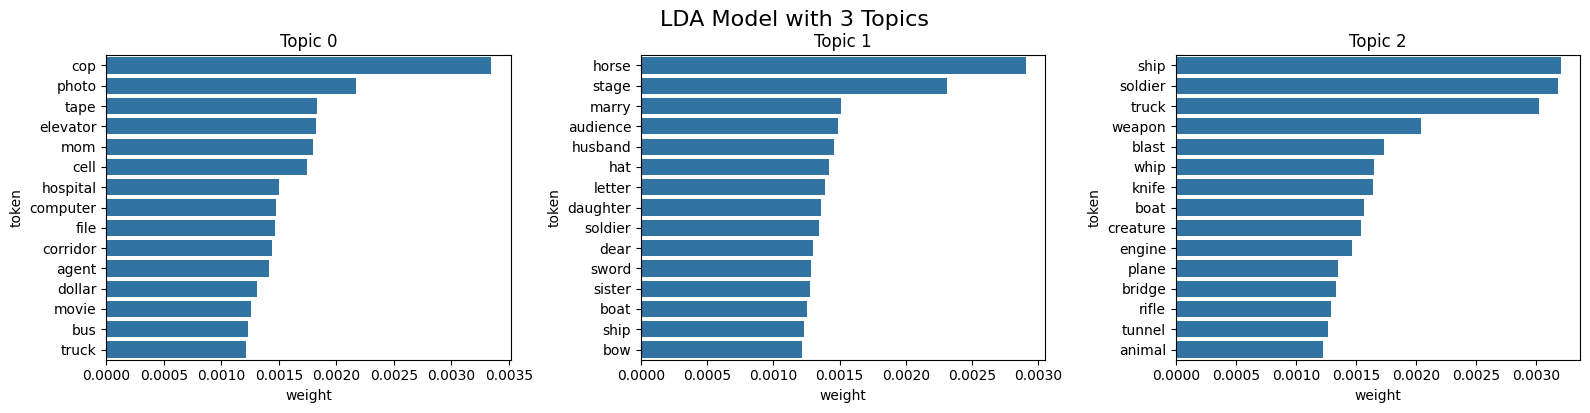


Training and visualizing 4-topic model:


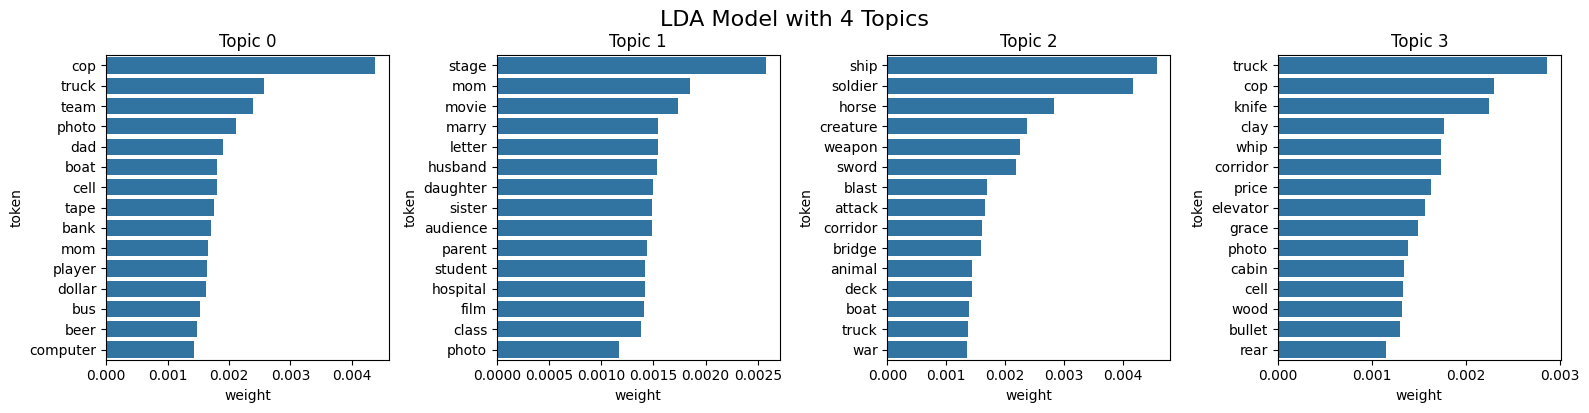


Training and visualizing 5-topic model:


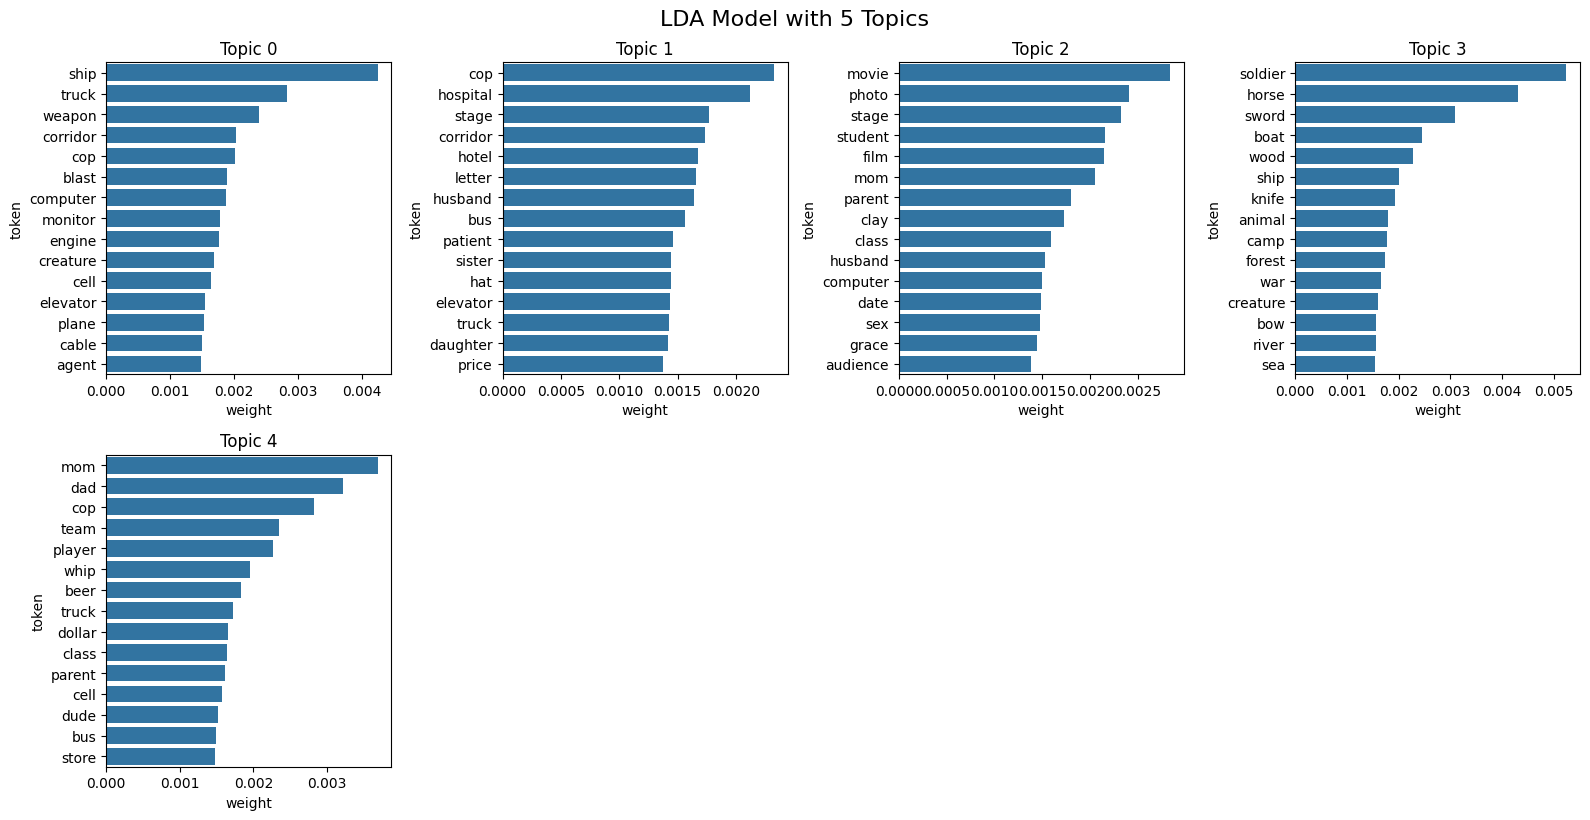


Training and visualizing 6-topic model:


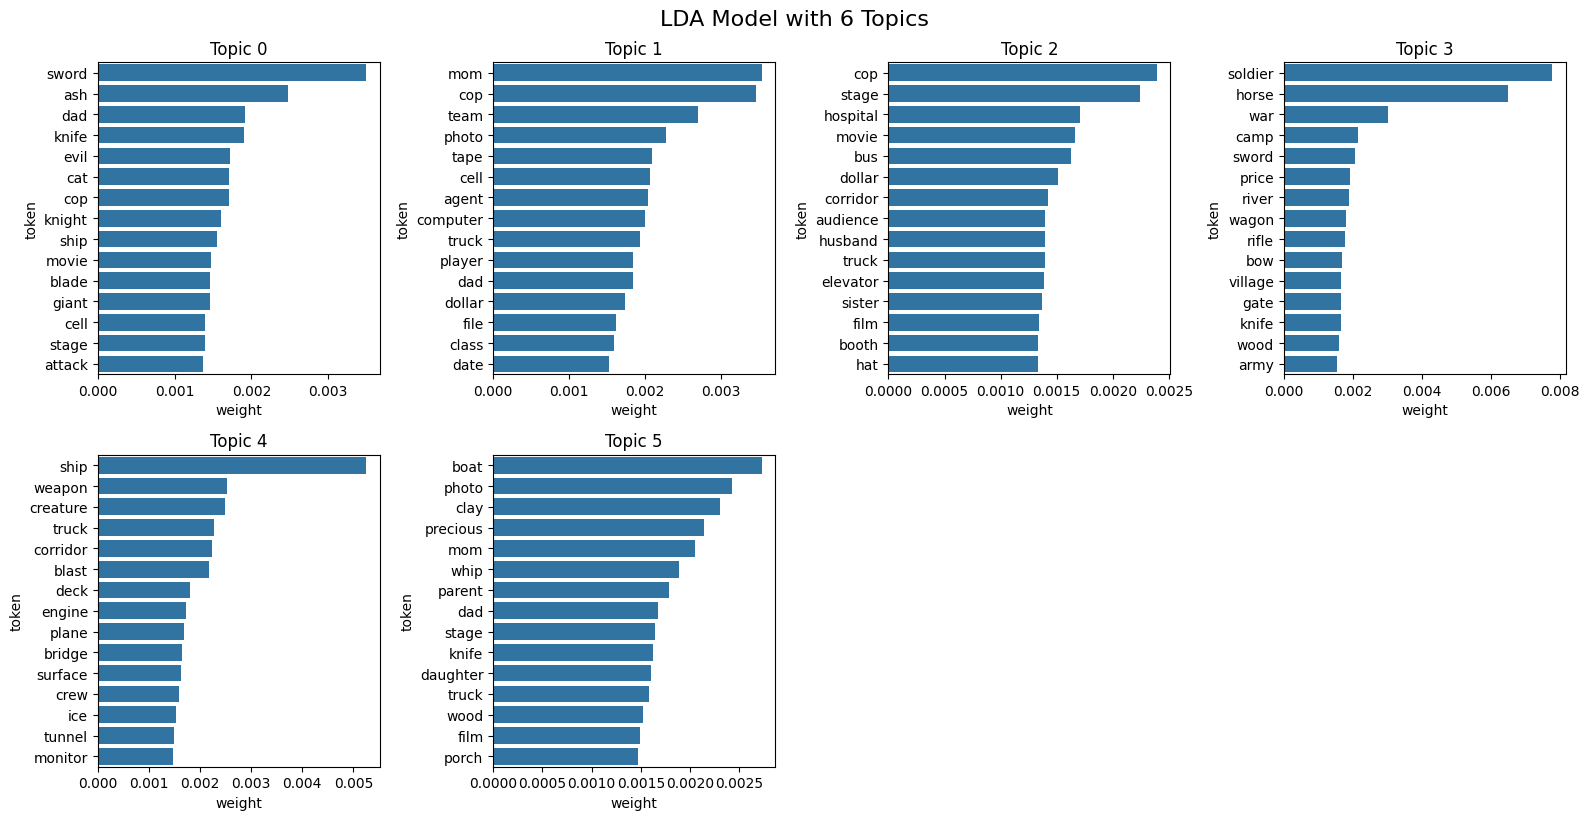

In [ ]:
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np

def visualize_topics(lda_model, num_topics, topn=15):

    # Calculate grid dims
    cols = min(4, num_topics)
    rows = math.ceil(num_topics / cols)

    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))

    # handles single topic case
    if num_topics == 1:
        axes = np.array([axes])
    # makes axes 2D array even when only one row
    elif rows == 1:
        axes = axes.reshape(1, -1)


    for i in range(num_topics):
        row, col = i // cols, i % cols

        # top terms for this topic
        topic_terms = lda_model.show_topic(topicid=i, topn=topn)

        # df for the terms and their weights
        df = pd.DataFrame(topic_terms, columns=['token', 'weight'])

        # horizontal bar plot
        sns.barplot(x='weight', y='token', data=df, orient='h', ax=axes[row, col])
        axes[row, col].set_title(f'Topic {i}')

    # hide empty subplots
    for i in range(num_topics, rows*cols):
        row, col = i // cols, i % cols
        axes[row, col].set_visible(False)

    plt.tight_layout()
    plt.suptitle(f'LDA Model with {num_topics} Topics', fontsize=16, y=1.02)
    plt.show()

# visualize models with different n_topic values (3, 4, 5, 6)

# 3 topic
print("\nTraining and visualizing 3-topic model:")
model_3_topics = gensim.models.LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=3,
    alpha='symmetric',
    eta=0.01,
    passes=10
)
visualize_topics(model_3_topics, 3)

# 4 topic
print("\nTraining and visualizing 4-topic model:")
model_4_topics = gensim.models.LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=4,
    alpha='symmetric',
    eta=0.01,
    passes=10
)
visualize_topics(model_4_topics, 4)

# 5 topic
print("\nTraining and visualizing 5-topic model:")
model_5_topics = gensim.models.LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=5,
    alpha=0.01,
    eta=0.01,
    passes=10
)
visualize_topics(model_5_topics, 5)

# 6 topic
print("\nTraining and visualizing 6-topic model:")
model_6_topics = gensim.models.LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=6,
    alpha='asymmetric',
    eta=0.01,
    passes=10
)
visualize_topics(model_6_topics, 6)

#### Examining selected num_topics model

In [ ]:
# Extract LDA topic distributions for each doc
def get_document_topics(lda_model, corpus, num_topics):
    """
    Get topic distribution for each document and return as a DataFrame
    """
    doc_topic_dists = np.zeros((len(corpus), num_topics))

    for i, bow in enumerate(corpus):
        # topic distribution for document
        topic_dist = lda_model.get_document_topics(bow, minimum_probability=0)
        # Convert to dense vector
        for topic_id, prob in topic_dist:
            doc_topic_dists[i, topic_id] = prob

    return doc_topic_dists

# Get topic distributions from our model (6 topics)
lda_features = get_document_topics(model_6_topics, bow_corpus, 6)

from gensim.models.coherencemodel import CoherenceModel

coherence_model = CoherenceModel(
    model=model_6_topics,
    texts=docs_3gram,
    dictionary=dictionary,
    coherence='c_v'
)

# Calculate the coherence score for the 6-topic model
coherence_score_6_topics = coherence_model.get_coherence()

print(f"Coherence Score for 6-topic model: {coherence_score_6_topics}")


# Create a DataFrame with the LDA features
topic_cols = [f'topic_{i}' for i in range(6)]
lda_features_df = pd.DataFrame(lda_features, columns=topic_cols)

# Add these features to the original dataframe
df_movies = df_movies.reset_index(drop=True)  # make sure indexes align
for col in topic_cols:
    df_movies[col] = lda_features_df[col]

# Display the first few rows with the new topic columns
print("First few rows with LDA topic distributions:")
display(df_movies[['title'] + topic_cols].head())

# Basic statistics of the topic distributions
print("\nSummary statistics of topic distributions:")
display(df_movies[topic_cols].describe())

# save the dataframe to a pickle file
df_movies.to_pickle('df_movies_lda.pkl')


Coherence Score for 6-topic model: 0.3575435573412924
First few rows with LDA topic distributions:


,title,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,Predator,0.000086,0.000056,0.000043,0.000035,0.999754,0.000026
1,Master and Commander,0.000413,0.000054,0.000042,0.366866,0.632600,0.000025
2,White Christmas,0.000202,0.000133,0.902809,0.096726,0.000069,0.000060
3,Fantastic Beasts: The Crimes of Grindelwald,0.564803,0.000091,0.000069,0.424132,0.010865,0.000041
4,Legend,0.415344,0.000046,0.000035,0.335635,0.248919,0.000021



Summary statistics of topic distributions:


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
count,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000
mean,0.085937,0.223638,0.248649,0.117783,0.189063,0.134930
std,0.196871,0.288048,0.298837,0.238293,0.289999,0.222806
min,0.000048,0.000032,0.000029,0.000023,0.000017,0.000014
25%,0.000152,0.000159,0.001752,0.000060,0.000057,0.000043
50%,0.002060,0.073649,0.096389,0.001749,0.017456,0.014305
75%,0.048824,0.383341,0.447678,0.098306,0.280423,0.177810
max,0.999593,0.999776,0.999756,0.999809,0.999819,0.999674


# Doc2Vec

In [5]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(tokens)]

#default parameters based on documentation
doc2vec_model = Doc2Vec(vector_size=200, window=5, min_count=5, workers=2, epochs=20)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

#doc2vec_model.save('/content/drive/MyDrive/Doc2vec/doc2vec.model')
#doc2vec_model = Doc2Vec.load('/content/drive/MyDrive/Doc2vec/doc2vec.model')

X_d2v = doc2vec_model.dv.vectors

### SVD vs PCA Comparison with TSNE

Applying Truncated SVD...
SVD with 50 components explains 58.26% of variance in 0.9191 seconds
SVD with 100 components explains 79.88% of variance in 1.1802 seconds
SVD with 150 components explains 93.05% of variance in 1.1885 seconds

Applying PCA...
PCA with 50 components explains 58.47% of variance in 0.8732 seconds
PCA with 100 components explains 79.95% of variance in 1.0761 seconds
PCA with 150 components explains 93.11% of variance in 1.2335 seconds

Computation Time Comparison:
50 components - SVD: 0.9191s, PCA: 0.8732s
100 components - SVD: 1.1802s, PCA: 1.0761s
150 components - SVD: 1.1885s, PCA: 1.2335s


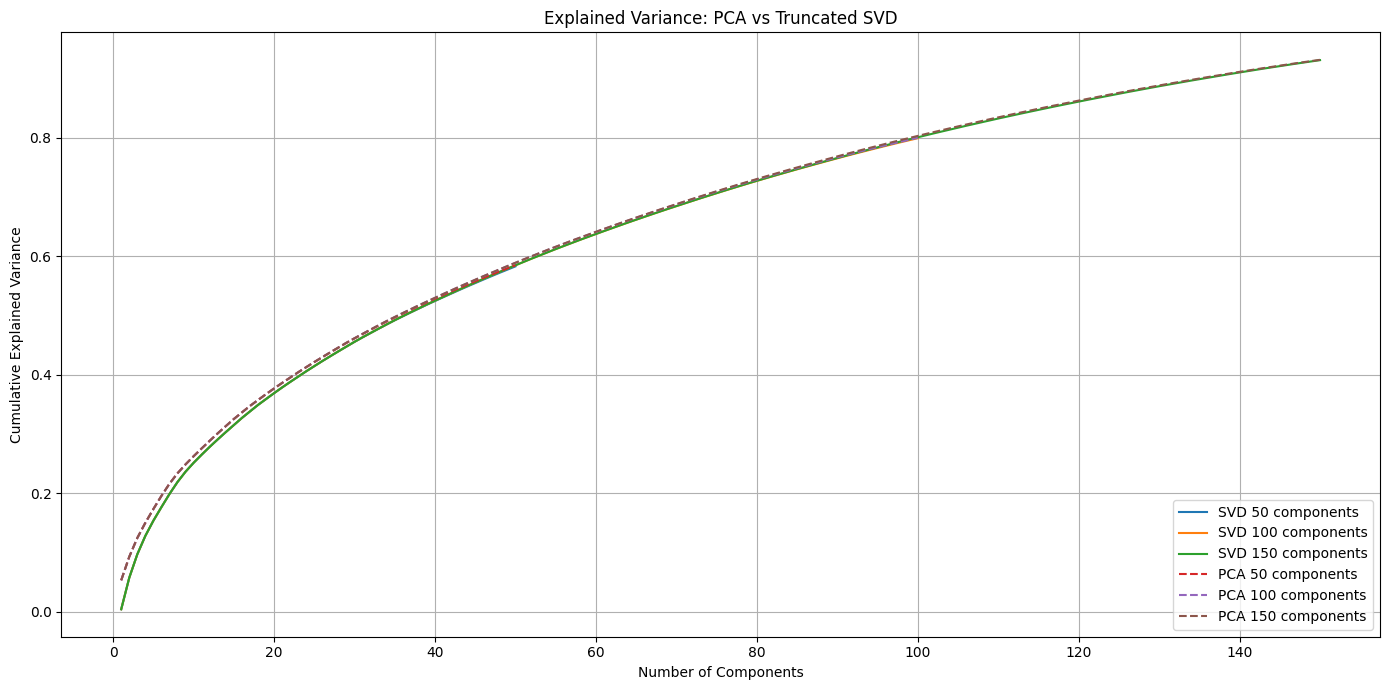

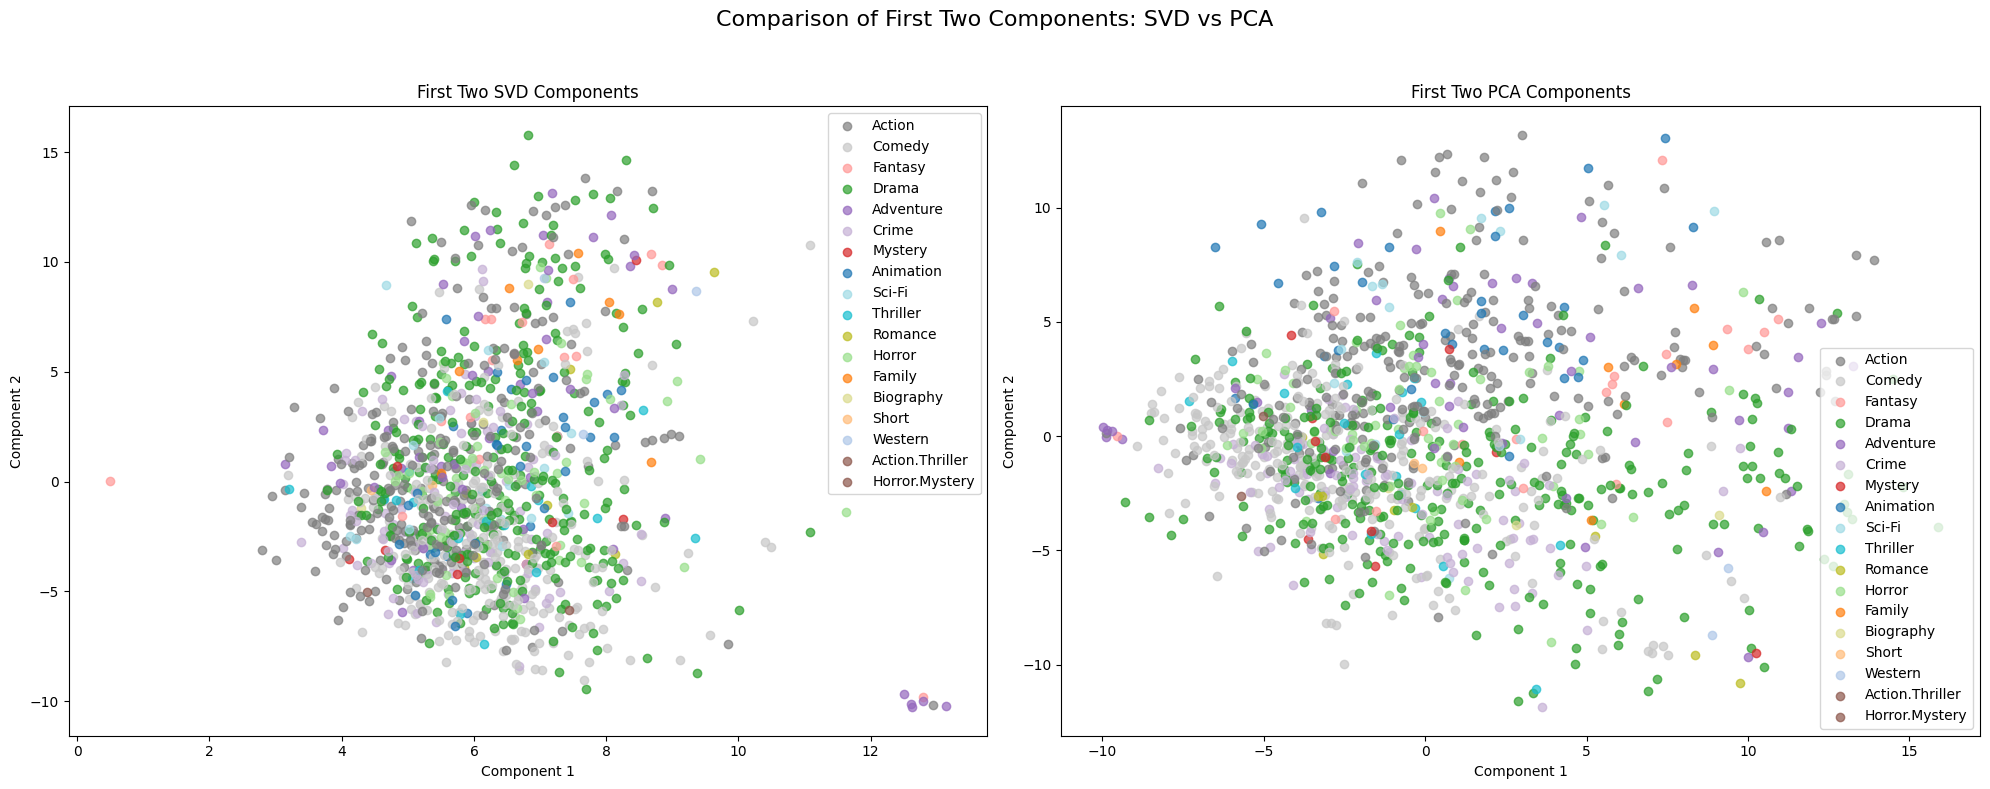


Applying t-SNE to original and reduced vectors...
t-SNE on original vectors took 2.0765 seconds
t-SNE on SVD-reduced vectors took 1.6488 seconds
t-SNE on PCA-reduced vectors took 1.6016 seconds


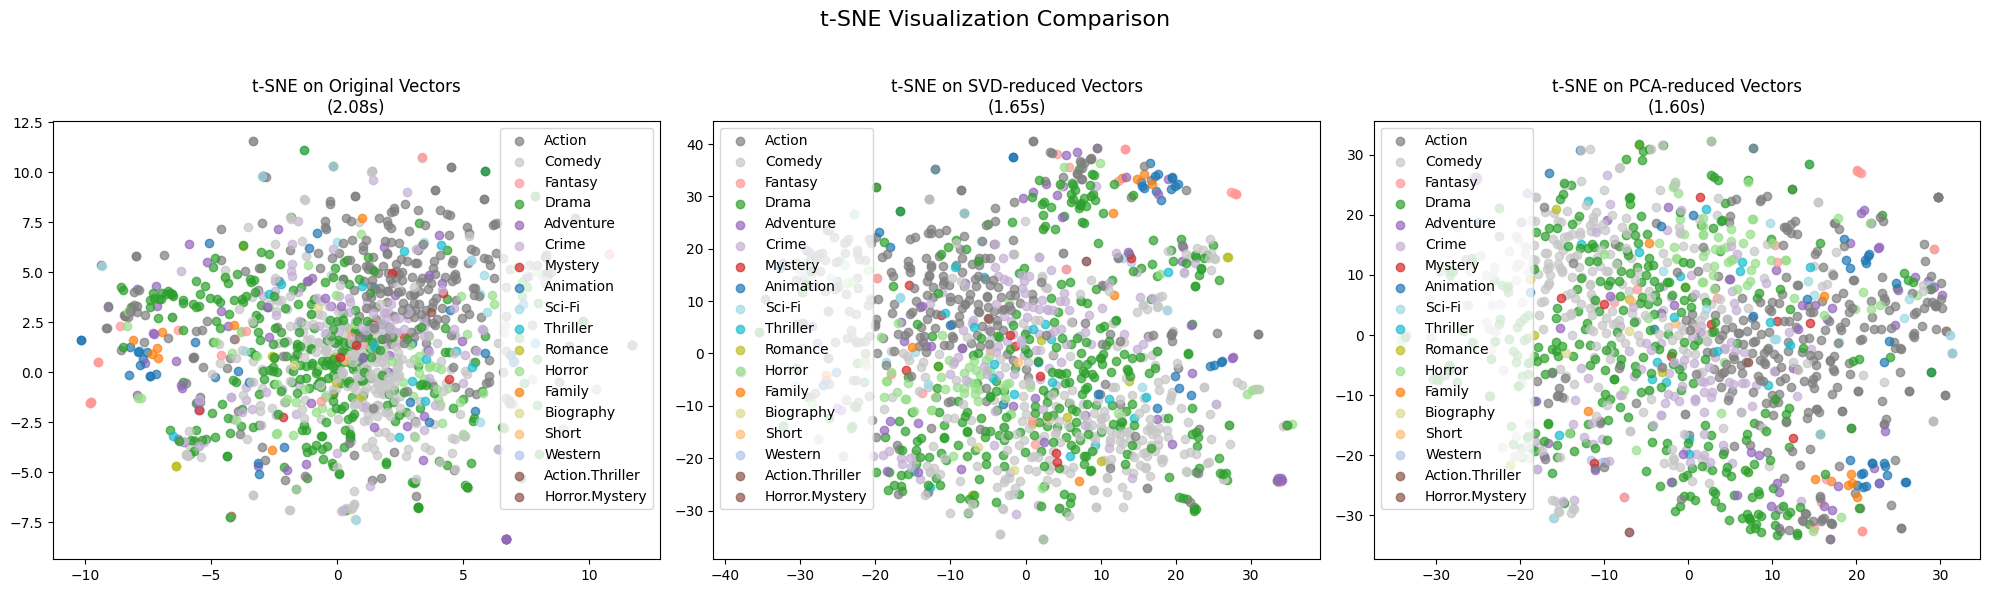


Analyzing genre cohesion...

Genre Cohesion Comparison:
        Genre  Count  SVD_Avg_Distance  PCA_Avg_Distance Better_Method  \
1               1209         15.437857         15.463230           SVD   
5       Drama    667         15.070551         15.093312           SVD   
20   Thriller    393         14.723092         14.759652           SVD   
17     Comedy    381         14.470216         14.492755           SVD   
15     Action    313         15.705275         15.746807           SVD   
11      Crime    218         13.774990         13.808746           SVD   
10  Adventure    213         16.941683         16.977011           SVD   
18    Romance    203         14.522475         14.537147           SVD   
21     Sci-Fi    171         15.237072         15.270626           SVD   
7      Horror    157         14.583456         14.623111           SVD   
9     Fantasy    136         16.129274         16.158867           SVD   
8     Mystery    123         14.688875         14.75944

<Figure size 1400x800 with 0 Axes>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
import pandas as pd
import time

movies = pd.read_csv('movies_svc.csv')

#status
print("Applying Truncated SVD...")
n_components_list = [50, 100, 150]
svd_results = {}

for n_comp in n_components_list:

    start_time = time.time()

    # init and fit SVD
    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    reduced_vectors = svd.fit_transform(X_d2v)

    svd_time = time.time() - start_time


    svd_results[n_comp] = {
        'model': svd,
        'vectors': reduced_vectors,
        'explained_variance_ratio': svd.explained_variance_ratio_,
        'cumulative_variance': np.cumsum(svd.explained_variance_ratio_),
        'computation_time': svd_time
    }

    print(f"SVD with {n_comp} components explains {svd_results[n_comp]['cumulative_variance'][-1]*100:.2f}% of variance in {svd_time:.4f} seconds")

# init PCA with same components
print("\nApplying PCA...")
pca_results = {}

for n_comp in n_components_list:
    start_time = time.time()

    # init and fit PCA
    pca = PCA(n_components=n_comp, random_state=42)
    pca_vectors = pca.fit_transform(X_d2v)

    pca_time = time.time() - start_time

    pca_results[n_comp] = {
        'model': pca,
        'vectors': pca_vectors,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'cumulative_variance': np.cumsum(pca.explained_variance_ratio_),
        'computation_time': pca_time
    }

    print(f"PCA with {n_comp} components explains {pca_results[n_comp]['cumulative_variance'][-1]*100:.2f}% of variance in {pca_time:.4f} seconds")

# computation time check
comp_times = {
    'Components': n_components_list,
    'SVD_Time': [svd_results[n]['computation_time'] for n in n_components_list],
    'PCA_Time': [pca_results[n]['computation_time'] for n in n_components_list]
}

print("\nComputation Time Comparison:")
for i, n in enumerate(n_components_list):
    print(f"{n} components - SVD: {comp_times['SVD_Time'][i]:.4f}s, PCA: {comp_times['PCA_Time'][i]:.4f}s")

# Variance Visualization
plt.figure(figsize=(14, 7))

# SVD variance curves
for n_comp in n_components_list:
    plt.plot(range(1, n_comp + 1), svd_results[n_comp]['cumulative_variance'],
             linestyle='-', label=f'SVD {n_comp} components')

# PCA variance curves
for n_comp in n_components_list:
    plt.plot(range(1, n_comp + 1), pca_results[n_comp]['cumulative_variance'],
             linestyle='--', label=f'PCA {n_comp} components')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance: PCA vs Truncated SVD')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Extract reduced vectors (50 components)
svd_vectors_50 = svd_results[50]['vectors']
pca_vectors_50 = pca_results[50]['vectors']

# 6. Extract unique genres
all_genres = set()
for genres in movies['genres']:
    for genre in genres.split(','):
        all_genres.add(genre.strip())

# color map for genres
unique_genres = list(all_genres)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_genres)))
genre_color_map = dict(zip(unique_genres, colors))

# comparison for first two components of SVD and PCA
plt.figure(figsize=(20, 8))
plt.suptitle('Comparison of First Two Components: SVD vs PCA', fontsize=16)


plt.subplot(1, 2, 1)
added_genres_svd = set()

# SVD points
for i, row in movies.iterrows():
    main_genre = row['genres'].split(',')[0].strip()
    color = genre_color_map[main_genre]

    label = main_genre if main_genre not in added_genres_svd else None
    plt.scatter(svd_vectors_50[i, 0], svd_vectors_50[i, 1],
                color=color, alpha=0.7, label=label)
    added_genres_svd.add(main_genre)

plt.title('First Two SVD Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()

# PCA subplot
plt.subplot(1, 2, 2)
added_genres_pca = set()

for i, row in movies.iterrows():
    main_genre = row['genres'].split(',')[0].strip()
    color = genre_color_map[main_genre]

    label = main_genre if main_genre not in added_genres_pca else None
    plt.scatter(pca_vectors_50[i, 0], pca_vectors_50[i, 1],
                color=color, alpha=0.7, label=label)
    added_genres_pca.add(main_genre)

plt.title('First Two PCA Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("\nApplying t-SNE to original and reduced vectors...")

# t-SNE on original vectors
start_time = time.time()
tsne_original = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result_original = tsne_original.fit_transform(X_d2v)
original_time = time.time() - start_time
print(f"t-SNE on original vectors took {original_time:.4f} seconds")

# t-SNE on SVD-reduced vectors
start_time = time.time()
tsne_svd = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result_svd = tsne_svd.fit_transform(svd_vectors_50)
svd_time = time.time() - start_time
print(f"t-SNE on SVD-reduced vectors took {svd_time:.4f} seconds")

# t-SNE on PCA-reduced vectors
start_time = time.time()
tsne_pca = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result_pca = tsne_pca.fit_transform(pca_vectors_50)
pca_time = time.time() - start_time
print(f"t-SNE on PCA-reduced vectors took {pca_time:.4f} seconds")


plt.figure(figsize=(20, 6))
plt.suptitle('t-SNE Visualization Comparison', fontsize=16)

plt.subplot(1, 3, 1)
added_genres1 = set()
for i, row in movies.iterrows():
    main_genre = row['genres'].split(',')[0].strip()
    color = genre_color_map[main_genre]

    label = main_genre if main_genre not in added_genres1 else None
    plt.scatter(tsne_result_original[i, 0], tsne_result_original[i, 1],
                color=color, alpha=0.7, label=label)
    added_genres1.add(main_genre)

plt.title(f't-SNE on Original Vectors\n({original_time:.2f}s)')
plt.legend()

# SVD subplot
plt.subplot(1, 3, 2)
added_genres2 = set()
for i, row in movies.iterrows():
    main_genre = row['genres'].split(',')[0].strip()
    color = genre_color_map[main_genre]

    label = main_genre if main_genre not in added_genres2 else None
    plt.scatter(tsne_result_svd[i, 0], tsne_result_svd[i, 1],
                color=color, alpha=0.7, label=label)
    added_genres2.add(main_genre)

plt.title(f't-SNE on SVD-reduced Vectors\n({svd_time:.2f}s)')
plt.legend()

# PCA subplot
plt.subplot(1, 3, 3)
added_genres3 = set()
for i, row in movies.iterrows():
    main_genre = row['genres'].split(',')[0].strip()
    color = genre_color_map[main_genre]

    label = main_genre if main_genre not in added_genres3 else None
    plt.scatter(tsne_result_pca[i, 0], tsne_result_pca[i, 1],
                color=color, alpha=0.7, label=label)
    added_genres3.add(main_genre)

plt.title(f't-SNE on PCA-reduced Vectors\n({pca_time:.2f}s)')
plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# genre cohesion for both PCA and SVD
print("\nAnalyzing genre cohesion...")
svd_genre_analysis = {}
pca_genre_analysis = {}

for genre in unique_genres:
    genre_indices = [i for i, row in movies.iterrows() if genre in row['genres']]

    if len(genre_indices) > 1:
        svd_genre_vecs = svd_vectors_50[genre_indices]
        pca_genre_vecs = pca_vectors_50[genre_indices]

        # centroids calculation
        svd_centroid = np.mean(svd_genre_vecs, axis=0)
        pca_centroid = np.mean(pca_genre_vecs, axis=0)

        # average distances to centroids calculation
        svd_distances = np.sqrt(np.sum((svd_genre_vecs - svd_centroid)**2, axis=1))
        pca_distances = np.sqrt(np.sum((pca_genre_vecs - pca_centroid)**2, axis=1))

        svd_avg_distance = np.mean(svd_distances)
        pca_avg_distance = np.mean(pca_distances)

        svd_genre_analysis[genre] = {
            'count': len(genre_indices),
            'avg_distance_to_centroid': svd_avg_distance
        }

        pca_genre_analysis[genre] = {
            'count': len(genre_indices),
            'avg_distance_to_centroid': pca_avg_distance
        }

#comparison df
genre_comparison = pd.DataFrame({
    'Genre': list(svd_genre_analysis.keys()),
    'Count': [info['count'] for info in svd_genre_analysis.values()],
    'SVD_Avg_Distance': [info['avg_distance_to_centroid'] for info in svd_genre_analysis.values()],
    'PCA_Avg_Distance': [info['avg_distance_to_centroid'] for info in pca_genre_analysis.values()]
})

# performance comparison
genre_comparison['Better_Method'] = genre_comparison.apply(
    lambda row: 'PCA' if row['PCA_Avg_Distance'] < row['SVD_Avg_Distance'] else 'SVD',
    axis=1
)

# Calculate improvement percentage
genre_comparison['Improvement_Pct'] = genre_comparison.apply(
    lambda row: ((max(row['SVD_Avg_Distance'], row['PCA_Avg_Distance']) -
                 min(row['SVD_Avg_Distance'], row['PCA_Avg_Distance'])) /
                max(row['SVD_Avg_Distance'], row['PCA_Avg_Distance']) * 100),
    axis=1
)

genre_comparison = genre_comparison.sort_values('Count', ascending=False)

print("\nGenre Cohesion Comparison:")
print(genre_comparison)

method_counts = genre_comparison['Better_Method'].value_counts()
print("\nNumber of genres where each method performs better:")
print(method_counts)

#cohesion comparison
plt.figure(figsize=(14, 8))
plt.suptitle('Genre Cohesion Comparison: SVD vs PCA', fontsize=16)

genres = genre_comparison['Genre']
x = np.arange(len(genres))
width = 0.35


### SVD Component Generation

In [7]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD

# Use your existing Doc2Vec vectors
##X_doc2vec = doc_vectors  # Your 200-dim Doc2Vec vectors

# Apply Truncated SVD to reduce dimensionality
n_components_list = [50, 100, 150]
svd_results = {}

for n_comp in n_components_list:
    # Initialize and fit TruncatedSVD
    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    reduced_vectors = svd.fit_transform(X_d2v)

    # Store results
    svd_results[n_comp] = {
        'model': svd,
        'vectors': reduced_vectors,
        'explained_variance_ratio': svd.explained_variance_ratio_,
        'cumulative_variance': np.cumsum(svd.explained_variance_ratio_)
    }

    print(f"SVD with {n_comp} components explains {svd_results[n_comp]['cumulative_variance'][-1]*100:.2f}% of variance")

# Choose the SVD vectors for further analysis (e.g., 50 components)
svd_vectors_100 = svd_results[100]['vectors']

# Save these vectors for later use
#np.save('doc2vec_svd_100.npy', svd_vectors_100)

SVD with 50 components explains 58.26% of variance
SVD with 100 components explains 79.88% of variance
SVD with 150 components explains 93.05% of variance


Results:  

SVD with 50 components explains 58.04% of variance

SVD with 100 components explains 79.77% of variance

SVD with 150 components explains 93.04% of variance


### SVD Component Visualization

Number of components needed for 80.0% variance: 100


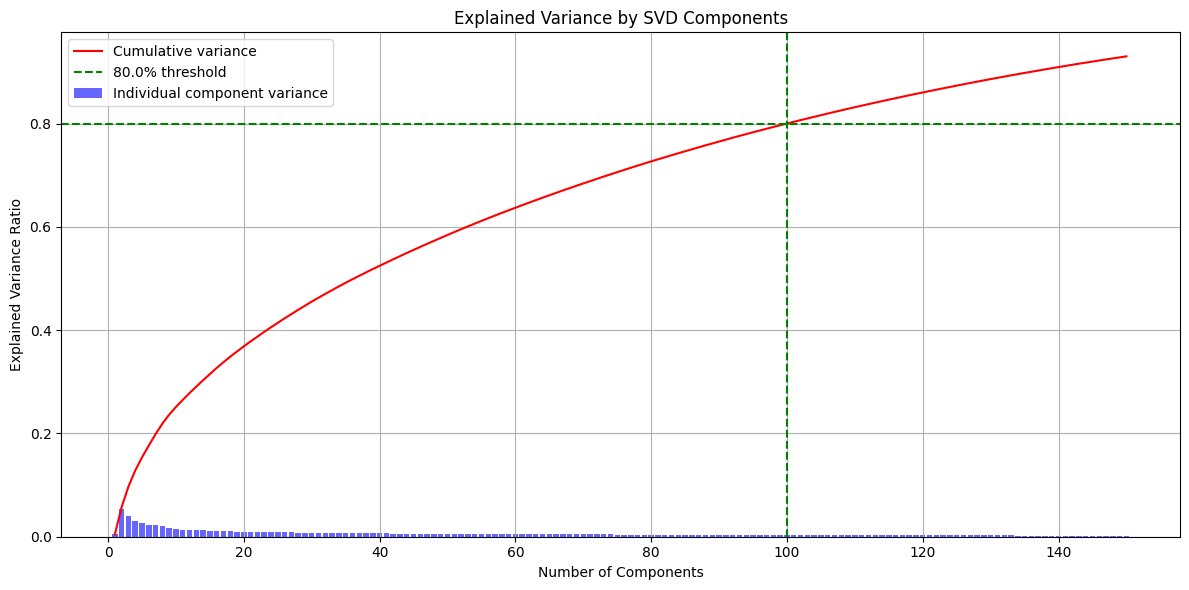

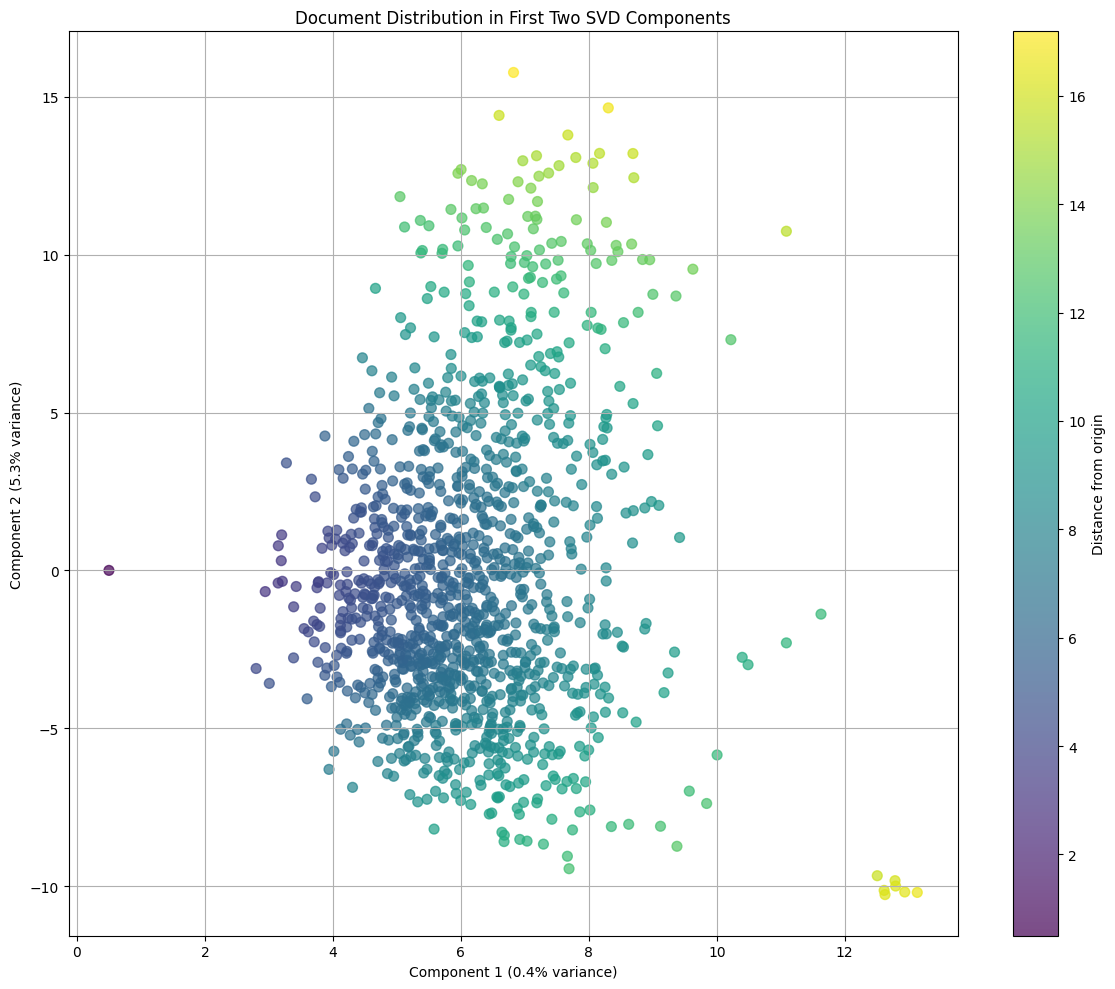

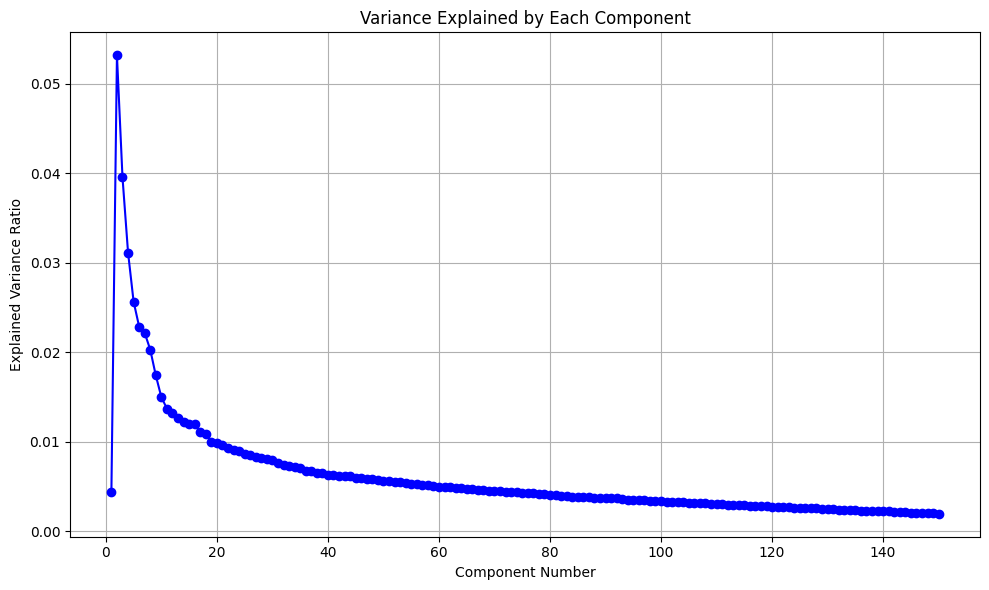

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# explained variance plot init
plt.figure(figsize=(12, 6))
explained_variance = svd.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# informative bar + line chart
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.6,
        color='blue', label='Individual component variance')
plt.plot(range(1, len(cumulative_explained_variance)+1), cumulative_explained_variance,
         'r-', label='Cumulative variance')

# dynamically calculate threshold
max_variance = cumulative_explained_variance[-1]
threshold = min(0.8, max_variance * 0.9)  # Either 80% or 90% of max available variance

# check for threshold
if np.any(cumulative_explained_variance >= threshold):
    components_needed = np.where(cumulative_explained_variance >= threshold)[0][0] + 1
    plt.axhline(y=threshold, color='green', linestyle='--',
                label=f'{threshold:.1%} threshold')
    plt.axvline(x=components_needed, color='green', linestyle='--')
    print(f"Number of components needed for {threshold:.1%} variance: {components_needed}")

else:
    # show the max variance if threshold not met
    plt.axhline(y=max_variance, color='green', linestyle='--',
                label=f'Max variance: {max_variance:.1%}')
    print(f"Even with all {len(explained_variance)} components, only {max_variance:.1%} variance is explained")

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by SVD Components')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# scatter plot of first 2 components
plt.figure(figsize=(12, 10))
plt.scatter(
    svd_vectors_100[:, 0],
    svd_vectors_100[:, 1],
    c=np.sqrt(svd_vectors_100[:, 0]**2 + svd_vectors_100[:, 1]**2),  # Color by distance from origin
    cmap='viridis',
    alpha=0.7,
    s=50
)

plt.colorbar(label='Distance from origin')
plt.xlabel(f'Component 1 ({explained_variance[0]*100:.1f}% variance)')
plt.ylabel(f'Component 2 ({explained_variance[1]*100:.1f}% variance)')
plt.title('Document Distribution in First Two SVD Components')
plt.grid(True)
plt.tight_layout()
plt.show()

# component significance decay
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance, 'bo-')
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Each Component')
plt.grid(True)
plt.tight_layout()
plt.show()

# Classification

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

df_movies = pd.read_pickle('df_movies_lda.pkl')

df_with_genres = df_movies.dropna(subset=['genres'])
df_without_genres = df_movies[df_movies['genres'].isna()].copy()

# for later use if wanted (manual genre assignment and testing)
df_without_genres.to_pickle('df_without_genres.pkl')

X = df_with_genres[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']]
y = df_with_genres['genres']

binarizer = MultiLabelBinarizer()
y_binarized = binarizer.fit_transform(y)

cols_to_display = [col for col in df_movies.columns if col != 'script' and col != 'cleaned_script']
print("Dataset without scripts:")
display(df_movies[cols_to_display].head())

# Display information about binarized genres
print("\nGenre Labels (Classes):")
print(binarizer.classes_)

# Create a DataFrame with movie titles binarized genres (multi)
genre_cols = binarizer.classes_
genre_df = pd.DataFrame(y_binarized, columns=genre_cols)

# Add the movie title for reference
genre_df['title'] = df_with_genres['title'].reset_index(drop=True)
genre_df['genres'] = df_with_genres['genres'].reset_index(drop=True)
display(genre_df.head(5))


Dataset without scripts:


,title,genres,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,Predator,"[Action, Horror, Sci-Fi, Thriller]",0.000086,0.000056,0.000043,0.000035,0.999754,0.000026
1,Master and Commander,"[Action, Drama]",0.000413,0.000054,0.000042,0.366866,0.632600,0.000025
2,White Christmas,"[Comedy, Romance]",0.000202,0.000133,0.902809,0.096726,0.000069,0.000060
3,Fantastic Beasts: The Crimes of Grindelwald,NaN,0.564803,0.000091,0.000069,0.424132,0.010865,0.000041
4,Legend,[Romance],0.415344,0.000046,0.000035,0.335635,0.248919,0.000021



Genre Labels (Classes):
['Action' 'Comedy' 'Crime' 'Drama' 'Horror' 'Romance' 'Sci-Fi' 'Thriller']


,Action,Comedy,Crime,Drama,Horror,Romance,Sci-Fi,Thriller,title,genres
0,1,0,0,0,1,0,1,1,Predator,"[Action, Horror, Sci-Fi, Thriller]"
1,1,0,0,1,0,0,0,0,Master and Commander,"[Action, Drama]"
2,0,1,0,0,0,1,0,0,White Christmas,"[Comedy, Romance]"
3,0,0,0,0,0,1,0,0,Legend,[Romance]
4,0,1,0,0,0,1,0,0,10 Things I Hate About You,"[Comedy, Romance]"


In [ ]:
from skmultilearn.model_selection import iterative_train_test_split

X_array = np.array(X)
y_array = np.array(y_binarized)

trainval_X, trainval_y, test_X, test_y = iterative_train_test_split(X_array, y_array, test_size=0.2)
train_X, train_y, val_X, val_y = iterative_train_test_split(trainval_X, trainval_y, test_size=0.2)

train_X = pd.DataFrame(train_X, columns=X.columns)
val_X = pd.DataFrame(val_X, columns=X.columns)
test_X = pd.DataFrame(test_X, columns=X.columns)

# Check distribution of genres in train, test, val
train_genre_dist = pd.DataFrame(train_y, columns=binarizer.classes_).sum()
val_genre_dist = pd.DataFrame(val_y, columns=binarizer.classes_).sum()
test_genre_dist = pd.DataFrame(test_y, columns=binarizer.classes_).sum()

print("Genre distribution in training set:")
display((train_genre_dist / len(train_y) * 100).sort_values(ascending=False))

print("Genre distribution in validation set:")
display((val_genre_dist / len(val_y) * 100).sort_values(ascending=False))

print("Genre distribution in test set:")
display((test_genre_dist / len(test_y) * 100).sort_values(ascending=False))

Genre distribution in training set:


Drama       56.258235
Thriller    32.542819
Comedy      32.015810
Action      26.218709
Crime       17.523057
Romance     17.127800
Sci-Fi      14.229249
Horror      13.175231
dtype: float64

Genre distribution in validation set:


Drama       57.219251
Thriller    33.155080
Comedy      32.620321
Action      26.737968
Crime       18.716578
Romance     17.112299
Sci-Fi      14.438503
Horror      13.368984
dtype: float64

Genre distribution in test set:


Drama       56.118143
Thriller    35.021097
Comedy      32.067511
Action      26.160338
Crime       21.097046
Romance     17.299578
Sci-Fi      15.189873
Horror      13.080169
dtype: float64

## TF-IDF Classifiers

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
import pandas as pd
import numpy as np

# load and clean
df_movies = pd.read_pickle('data.pkl')
df_with_genres = df_movies.dropna(subset=['genres'])
df_without_genres = df_movies[df_movies['genres'].isna()].copy()
df_without_genres.to_pickle('df_without_genres.pkl')

X = df_with_genres['tokens']
y = df_with_genres['genres']

# binarize genres
binarizer = MultiLabelBinarizer()
y_binarized = binarizer.fit_transform(y)

# split, preserve label balance
X_array = np.array(X, dtype=object)
y_array = np.array(y_binarized)

X_train, y_train, X_test, y_test = iterative_train_test_split(
    X_array.reshape(-1, 1), y_array, test_size=0.2
)

X_train = pd.Series(X_train.ravel()).apply(lambda tokens: ' '.join(tokens))
X_test = pd.Series(X_test.ravel()).apply(lambda tokens: ' '.join(tokens))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD

# final chosen pipeline and parameters
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('fs', SelectKBest(chi2)),
    ('classifier', OneVsRestClassifier(LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)))
])

param_grid = {
    'classifier__estimator__C': [100],
    'fs__k': [3000],
    'vectorizer__min_df': [0.1],
    'vectorizer__max_df': [0.95]
}

# fit
lrgrid = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5), scoring='f1_macro', n_jobs=-1, error_score=False)
lrgrid.fit(X_train, y_train)

print("Best params:", lrgrid.best_params_)
print("Best cross-val f1_macro:", lrgrid.best_score_)

Best params: {'classifier__estimator__C': 100, 'fs__k': 3000, 'vectorizer__max_df': 0.95, 'vectorizer__min_df': 0.1}
Best cross-val f1_macro: 0.5978962142603037


In [ ]:
from sklearn.metrics import f1_score

# get test score
y_pred = lrgrid.predict(X_test)
print(f"Test macro F!: {f1_score(y_test, y_pred, average='macro')}")

Test macro F!: 0.6213844043782559


In [ ]:
from sklearn.svm import LinearSVC

# final chosen pipeline and parameters
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('fs', SelectKBest(chi2)),
    ('classifier', OneVsRestClassifier(LinearSVC(penalty='l2', max_iter=10000)))
])

param_grid = {
    'classifier__estimator__C': [50],
    'fs__k': [5000],
    'vectorizer__min_df': [0.05],
    'vectorizer__max_df': [0.95]
}

# fit
svcgrid = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
svcgrid.fit(X_train, y_train)

print("Best params:", svcgrid.best_params_)
print("Best cross-val f1_macro:", svcgrid.best_score_)

Best params: {'classifier__estimator__C': 50, 'fs__k': 5000, 'vectorizer__max_df': 0.95, 'vectorizer__min_df': 0.05}
Best cross-val f1_macro: 0.5944398082751233


In [ ]:
from sklearn.metrics import f1_score

# get test score
y_pred = svcgrid.predict(X_test)
print(f"Test macro F!: {f1_score(y_test, y_pred, average='macro')}")

Test macro F!: 0.6414663111852578


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2

# best performing model, final chosen pipeline and parameters
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('fs', SelectKBest(chi2)),
    ('classifier', OneVsRestClassifier(RandomForestClassifier(class_weight='balanced', random_state=42)))
])

param_grid = {
    'classifier__estimator__n_estimators': [300],
    'classifier__estimator__min_samples_leaf': [9],
    'fs__k': [150],
    'vectorizer__min_df': [0.05],
    'vectorizer__max_df': [1.0]
}

# fit
rfgrid = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
rfgrid.fit(X_train, y_train)

print("Best params:", rfgrid.best_params_)
print("Best cross-val f1_macro:", rfgrid.best_score_)

Best params: {'classifier__estimator__min_samples_leaf': 9, 'classifier__estimator__n_estimators': 300, 'fs__k': 150, 'vectorizer__max_df': 1.0, 'vectorizer__min_df': 0.05}
Best cross-val f1_macro: 0.6176397618285785


Test Macro F1: 0.6015551183045753


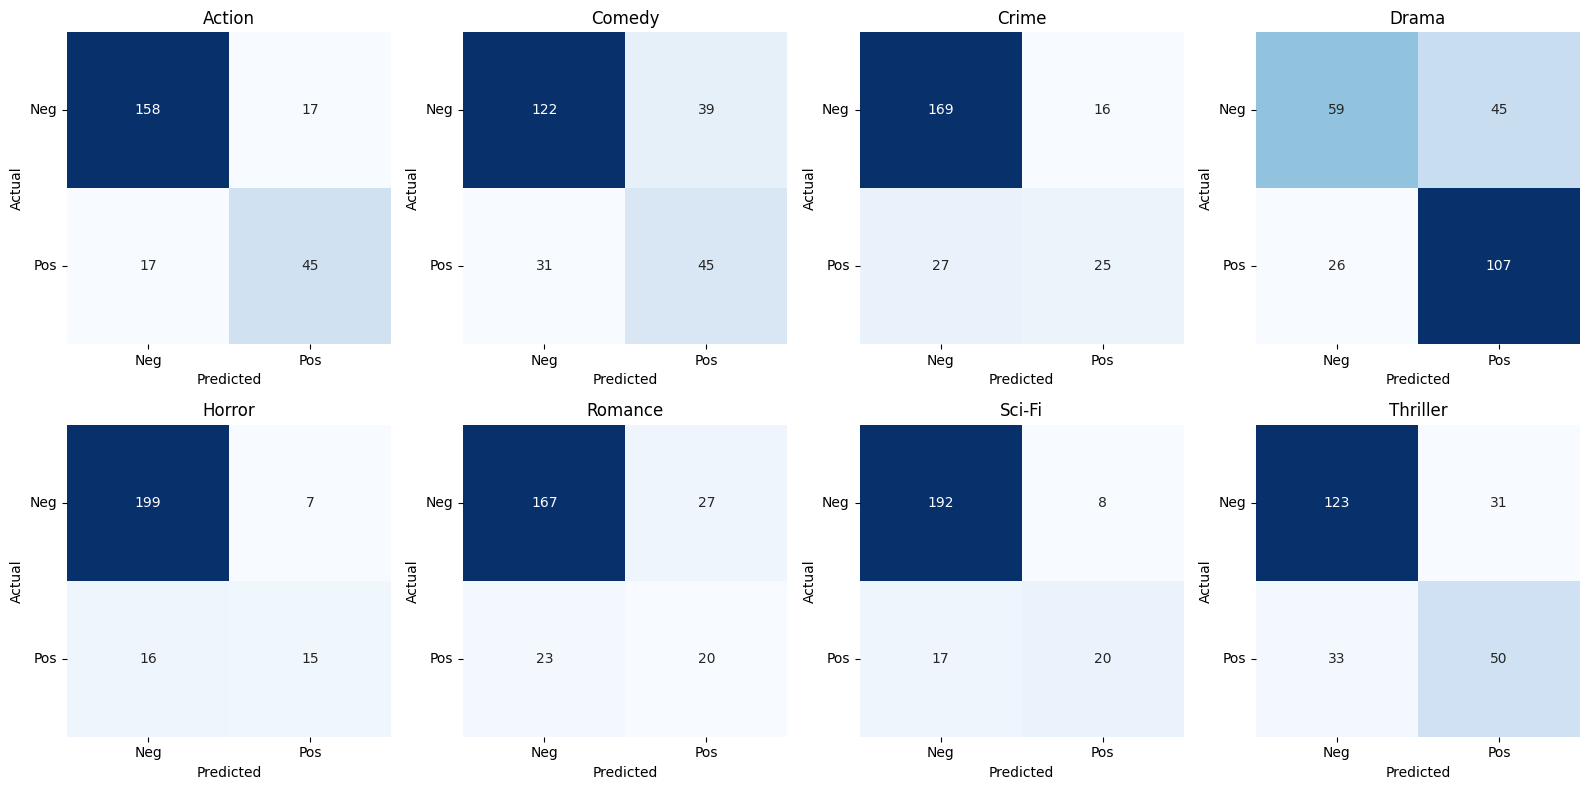

In [ ]:
from sklearn.metrics import f1_score

y_pred = rfgrid.predict(X_test)

print(f'Test Macro F1: {f1_score(y_test, y_pred, average="macro")}')

# display confusion matrix for each genre
confusion_matrices(y_test, y_pred, binarizer.classes_)

## Doc2Vec Classifiers

### GridSearch

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputClassifier

#movies = pd.read_csv('d2vmovies.csv')

X_d2v = svd_vectors_100
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_with_genres['genres'])

print(y.__len__())

X_train, X_test, y_train, y_test = train_test_split(X_d2v, y, test_size=0.2, random_state=42)

# pipeline without feature selection
pipeline = Pipeline([
    ('feature_selection', SelectKBest()),  # score_func placeholder
    ('model', None)
])

# non negative transformation because SVD vectors which may have negative values,
# and chi2 requires non-negative values
X_train_nonneg = np.copy(X_train)
X_test_nonneg = np.copy(X_test)

# create non neg data if needed
min_val = X_train_nonneg.min()
if min_val < 0:
    X_train_nonneg -= min_val
    X_test_nonneg -= min_val


models = {
    'svm_linear': MultiOutputClassifier(SVC(kernel='linear', probability=True)),
    'svm_rbf': MultiOutputClassifier(SVC(kernel='rbf', probability=True)),
    'random_forest': RandomForestClassifier(),  # RandomForest natively supports multi-output
}

# feature selection methods
feature_selectors = {
    'f_classif': f_classif,
    'mutual_info_classif': mutual_info_classif,
}

results = []


for model_name, model in models.items():
    print(f"Running grid search for {model_name}...")

    # parameter grid without feature selection
    if model_name == 'svm_linear' or model_name == 'svm_rbf':
        param_grid = {
            'estimator__C': [0.1, 1, 10]  # MultiOutputClassifier
        }
    elif model_name == 'random_forest':
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20]
        }

    # testing different number of features on different selection methods
    for selector_name, selector_func in feature_selectors.items():
        print(f"  Testing feature selector: {selector_name}")

        for k in [30, 50, 70]:
            print(f"    Testing k={k} features")

            # summing the importances across all labels to get overall importance
            all_importances = np.zeros(X_train.shape[1])

            # feature importance per genre
            for j in range(y_train.shape[1]):
                # Get the binary values for this label
                y_train_label = y_train[:, j]

                X_train_selector = X_train_nonneg if selector_name == 'chi2' else X_train

                try:
                    selector = SelectKBest(selector_func, k='all')
                    selector.fit(X_train_selector, y_train_label)

                    # Add the scores to our running total
                    all_importances += selector.scores_
                except Exception as e:
                    print(f"      Error with label {j}: {e}")
                    continue

            # extracting indices of the top k features across all labels
            selected_indices = np.argsort(all_importances)[-k:]

            #feature set of selected indices
            X_train_selected = X_train[:, selected_indices]
            X_test_selected = X_test[:, selected_indices]

            # model training
            try:
                if model_name == 'svm_linear':
                    current_model = MultiOutputClassifier(SVC(kernel='linear', probability=True))
                elif model_name == 'svm_rbf':
                    current_model = MultiOutputClassifier(SVC(kernel='rbf', probability=True))
                else:
                    current_model = RandomForestClassifier()

                # cross-validation
                grid_search = GridSearchCV(
                    current_model,
                    param_grid,
                    cv=5,
                    scoring='f1_macro',
                    n_jobs=-1
                )

                grid_search.fit(X_train_selected, y_train)

                test_score = grid_search.score(X_test_selected, y_test)

                results.append({
                    'model': model_name,
                    'feature_selector': selector_name,
                    'k': k,
                    'best_cv_score': grid_search.best_score_,
                    'test_score': test_score,
                    'best_params': grid_search.best_params_,
                    'selected_indices': selected_indices
                })

                print(f"      CV score: {grid_search.best_score_:.4f}")
                print(f"      Test score: {test_score:.4f}")

            except Exception as e:
                print(f"      Error with model: {e}")

    print("-" * 50)


### SVM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    f1_score, roc_curve, auc, confusion_matrix,
    classification_report, precision_recall_curve, average_precision_score
)
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns
from itertools import cycle
import os
from IPython.display import Image, display

genre_mapping = {
    ',': 'Comedy',
    '-': 'Documentary',
    '.': 'Short_Dot',
    'A': 'Adventure',
    'B': 'Biography',
    'C': 'Crime',
    'D': 'Drama',
    'F': 'Family',
    'H': 'Horror',
    'M': 'Music',
    'N': 'Animation_N',
    'R': 'Romance_R',
    'S': 'Sport',
    'T': 'Thriller',
    'W': 'War',
    'a': 'Action',
    'c': 'Comedy_c',
    'd': 'Drama_d',
    'e': 'Comedy_e',
    'g': 'Mystery_g',
    'h': 'History',
    'i': 'Sci-Fi',
    'l': 'Musical',
    'm': 'Mystery_m',
    'n': 'Fantasy',
    'o': 'Horror_o',
    'p': 'Film-Noir',
    'r': 'Romance_r',
    's': 'Short_s',
    't': 'Animation_t',
    'u': 'Western',
    'v': 'Adventure_v',
    'y': 'Mystery_y',
    ' ': 'Unknown'
}


mlb = MultiLabelBinarizer()
y = mlb.fit_transform(movies_with_genres['genres'])
genre_names = mlb.classes_

X_train, X_test, y_train, y_test = train_test_split(
    X_d2v, y, test_size=0.2, random_state=42
)

selectors = {
    'mutual_info_classif': mutual_info_classif,
    'f_classif': f_classif
}

feature_counts = [30, 50, 70, 100]
selector_results = {}

feature_selection_scores = {
    'method': [],
    'feature_count': [],
    'f1_score': []
}

#get top k features aggregated across all labels
def get_top_features(X, y, selector_func, k):
    all_importances = np.zeros(X.shape[1])
    for j in range(y.shape[1]):
        try:
            selector = SelectKBest(selector_func, k='all')
            selector.fit(X, y[:, j])
            all_importances += selector.scores_
        except Exception as e:
            print(f"Error with label {j}: {e}")
            continue
    return np.argsort(all_importances)[-k:]

for selector_name, selector_func in selectors.items():
    print(f"Testing {selector_name}...")
    selector_results[selector_name] = {}

    for k in feature_counts:
        print(f"  With {k} features...")

        # get top features for this selector
        selected_indices = get_top_features(X_train, y_train, selector_func, k)

        # reduced feature sets
        X_train_selected = X_train[:, selected_indices]
        X_test_selected = X_test[:, selected_indices]

        base_model = LinearSVC(C=1.0, max_iter=10000)
        calibrated_model = CalibratedClassifierCV(base_model, cv='prefit')
        model = MultiOutputClassifier(calibrated_model)

        # fit the base model to each output
        estimators = []
        for j in range(y_train.shape[1]):
            # skip genres with too few examples
            if np.sum(y_train[:, j]) < 5:
                print(f"    Warning: Genre '{genre_names[j]}' has fewer than 5 examples, using dummy classifier")
                from sklearn.dummy import DummyClassifier
                estimator = DummyClassifier(strategy='prior')
            else:
                # fit base classifier
                estimator = LinearSVC(C=1.0, max_iter=10000)

            # fit estimator to its target column
            estimator.fit(X_train_selected, y_train[:, j])

            # check for dummy
            if not isinstance(estimator, DummyClassifier):
                # Calibrate the fitted classifier
                calibrated = CalibratedClassifierCV(estimator, cv='prefit')
                calibrated.fit(X_train_selected, y_train[:, j])
                estimators.append(calibrated)
            else:
                estimators.append(estimator)

        # MultiOutputClassifier init with the pre-fitted models
        model = MultiOutputClassifier(base_model)  # base_model is just a placeholder
        model.estimators_ = estimators

        # Predict
        y_pred = np.array([est.predict(X_test_selected) for est in model.estimators_]).T

        # F1 score
        f1 = f1_score(y_test, y_pred, average='macro')

        selector_results[selector_name][k] = {
            'model': model,
            'selected_indices': selected_indices,
            'f1_score': f1,
            'X_train': X_train_selected,
            'X_test': X_test_selected,
            'y_pred': y_pred
        }

        feature_selection_scores['method'].append(selector_name)
        feature_selection_scores['feature_count'].append(k)
        feature_selection_scores['f1_score'].append(f1)

        print(f"    F1 Score: {f1:.4f}")

# feature selection comparison visualization
plt.figure(figsize=(10, 6))
df_scores = pd.DataFrame(feature_selection_scores)

# grouped bar chart
sns.barplot(
    x='feature_count',
    y='f1_score',
    hue='method',
    data=df_scores
)

plt.title('F1 Score by Feature Selection Method and Feature Count')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score (Macro)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('feature_selection_comparison.png')
plt.close()

try:
    display(Image(filename='feature_selection_comparison.png'))
except Exception as e:
    print(f"Could not display the image: {e}")
    print("The image has been saved as 'feature_selection_comparison.png'")

# best model configuration
best_f1 = 0
best_config = None

for method, results in selector_results.items():
    for k, result in results.items():
        if result['f1_score'] > best_f1:
            best_f1 = result['f1_score']
            best_config = {
                'method': method,
                'k': k,
                'model': result['model'],
                'X_test': result['X_test'],
                'y_pred': result['y_pred'],
                'selected_indices': result['selected_indices']
            }

print(f"\nBest configuration: {best_config['method']} with {best_config['k']} features")
print(f"Best F1 score: {best_f1:.4f}")

#evaluation of best model
best_model = best_config['model']
X_test_selected = best_config['X_test']
y_pred = best_config['y_pred']

# robability estimates for ROC curves
y_pred_proba = []
for est in best_model.estimators_:
    # Check if the estimator supports predict_proba
    if hasattr(est, 'predict_proba'):
        y_pred_proba.append(est.predict_proba(X_test_selected)[:, 1])
    else:
        # Create dummy probabilities based on predictions
        probs = est.predict(X_test_selected).astype(float)
        y_pred_proba.append(probs)

y_pred_proba = np.array(y_pred_proba).T

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=genre_names, zero_division=0))

# df for per-genre metrics and mappings
f1_scores = f1_score(y_test, y_pred, average=None, zero_division=0)
genre_df = pd.DataFrame({
    'code': genre_names,
    'genre': [genre_mapping.get(code, f'Unknown-{code}') for code in genre_names],
    'f1_score': f1_scores,
    'support': y_test.sum(axis=0)
})

# display genres by F1 score
print("\nGenres Ranked by F1 Score:")
print(genre_df.sort_values('f1_score', ascending=False))

# per-genre F1 Scores visualization with full genre names
df_genre_f1 = genre_df.sort_values('f1_score', ascending=False)
plt.figure(figsize=(16, 10))
ax = sns.barplot(x='genre', y='f1_score', data=df_genre_f1, hue='support', palette='viridis')
plt.title('F1 Score by Genre (with sample counts)')
plt.xlabel('Genre')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('genre_f1_scores.png')
plt.close()

try:
    display(Image(filename='genre_f1_scores.png'))
except Exception as e:
    print(f"Could not display the image: {e}")
    print("The image has been saved as 'genre_f1_scores.png'")

# 5.3: Confusion Matrices - for top 5 most common genres
genre_counts = y_test.sum(axis=0)
top_genres_idx = np.argsort(genre_counts)[-5:]  # 5 most common genres
top_genres_names = [genre_mapping.get(genre_names[i], genre_names[i]) for i in top_genres_idx]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, genre_idx in enumerate(top_genres_idx):
    if i >= len(axes):
        break

    cm = confusion_matrix(y_test[:, genre_idx], y_pred[:, genre_idx])

    # Normalize confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)  # Handle division by zero

    # Get full genre name
    full_genre_name = genre_mapping.get(genre_names[genre_idx], genre_names[genre_idx])

    sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues',
                xticklabels=['Not ' + full_genre_name, full_genre_name],
                yticklabels=['Not ' + full_genre_name, full_genre_name],
                ax=axes[i])

    axes[i].set_title(f'Confusion Matrix: {full_genre_name}')

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('top_genres_confusion_matrices.png')
plt.close()

try:
    display(Image(filename='top_genres_confusion_matrices.png'))
except Exception as e:
    print(f"Could not display the image: {e}")
    print("The image has been saved as 'top_genres_confusion_matrices.png'")

# ROC Curves for t5
plt.figure(figsize=(12, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for genre_idx, color, genre_name in zip(top_genres_idx, colors, top_genres_names):
    try:
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test[:, genre_idx], y_pred_proba[:, genre_idx])
        roc_auc = auc(fpr, tpr)

        # Plot
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'{genre_name} (AUC = {roc_auc:.2f})')
    except Exception as e:
        print(f"Could not generate ROC curve for {genre_name}: {e}")
        continue

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Top Genres')
plt.legend(loc="lower right")
plt.grid(linestyle='--', alpha=0.7)
plt.savefig('roc_curves.png')
plt.close()

try:
    display(Image(filename='roc_curves.png'))
except Exception as e:
    print(f"Could not display the image: {e}")
    print("The image has been saved as 'roc_curves.png'")

plt.figure(figsize=(12, 8))

for genre_idx, color, genre_name in zip(top_genres_idx, colors, top_genres_names):
    try:
        precision, recall, _ = precision_recall_curve(
            y_test[:, genre_idx], y_pred_proba[:, genre_idx]
        )
        avg_precision = average_precision_score(
            y_test[:, genre_idx], y_pred_proba[:, genre_idx]
        )

        # Plot
        plt.plot(recall, precision, color=color, lw=2,
                 label=f'{genre_name} (AP = {avg_precision:.2f})')
    except Exception as e:
        print(f"Could not generate PR curve for {genre_name}: {e}")
        continue

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Top Genres')
plt.legend(loc="best")
plt.grid(linestyle='--', alpha=0.7)
plt.savefig('precision_recall_curves.png')
plt.close()

try:
    display(Image(filename='precision_recall_curves.png'))
except Exception as e:
    print(f"Could not display the image: {e}")
    print("The image has been saved as 'precision_recall_curves.png'")

if best_config['method'] == 'mutual_info_classif' or best_config['method'] == 'f_classif':
    feature_importance = np.zeros(X.shape[1])
    selector_func = selectors[best_config['method']]

    for j in range(y_train.shape[1]):
        try:
            selector = SelectKBest(selector_func, k='all')
            selector.fit(X_train, y_train[:, j])
            feature_importance += selector.scores_
        except Exception as e:
            print(f"Error calculating importance for genre {j}: {e}")
            continue

    top_indices = np.argsort(feature_importance)[-20:]  # Top 20 features

    plt.figure(figsize=(12, 8))
    plt.barh(
        range(len(top_indices)),
        feature_importance[top_indices],
        align='center'
    )
    plt.yticks(range(len(top_indices)), [f'SVD_{i}' for i in top_indices])

    if best_config['method'] == 'mutual_info_classif':
        plt.xlabel('Mutual Information Score (Summed Across Genres)')
    else:
        plt.xlabel('F-Statistic Score (Summed Across Genres)')

    plt.title('Top 20 Most Important SVD Components')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()

    try:
        display(Image(filename='feature_importance.png'))
    except Exception as e:
        print(f"Could not display the image: {e}")
        print("The image has been saved as 'feature_importance.png'")

test_indices = np.arange(len(movies))[len(X_train):]

results_df = pd.DataFrame()

results_df['title'] = movies.iloc[test_indices]['title'].values
results_df['genres'] = movies.iloc[test_indices]['genres'].values

# SVD features (only 10 selected for sample)
for i in range(min(10, X_test_selected.shape[1])):
    results_df[f'component_{i}'] = X_test_selected[:, i]

# predicted probabilities for each genre
if hasattr(best_model.estimators_[0], 'predict_proba'):
    for i, genre_code in enumerate(genre_names):
        genre_name = genre_mapping.get(genre_code, genre_code)
        results_df[f'proba_{genre_name}'] = y_pred_proba[:, i]

# binary predictions for key genres
key_genres = ['Sci-Fi', 'Thriller', 'Horror', 'Action', 'Comedy', 'Drama', 'Romance', 'Crime']
for genre in key_genres:
    # find all the genre codes that map to this genre
    genre_codes = [code for code, name in genre_mapping.items() if name.startswith(genre)]

    if genre_codes:
        results_df[f'predicted_{genre}'] = 0
        for code in genre_codes:
            if code in genre_names:
                idx = list(genre_names).index(code)
                results_df[f'predicted_{genre}'] |= y_pred[:, idx].astype(int)
    else:
        results_df[f'predicted_{genre}'] = 0

# Save the results
results_df.to_csv('movie_genre_predictions.csv', index=False)

# Display the first few rows
print("\nSample of Prediction Results:")
print(results_df.head())


output_path = "/content/drive/MyDrive/Doc2vec/"  # Change this to your preferred path
os.makedirs(output_path, exist_ok=True)

model_file_path = os.path.join(output_path, "svd_genre_results.csv")
results_df.to_csv(model_file_path, index=False)

# Check which visualization files were created
print("\nGenerated Visualization Files:")
for f in os.listdir():
    if f.endswith('.png'):
        print(f"- {f}")

print("\nAll evaluations complete! Visualizations have been saved and displayed.")

In [ ]:
import os
import pandas as pd
import numpy as np

# Define the output path
output_path = "/content/drive/MyDrive/project_results/"  # Change this to your preferred path
os.makedirs(output_path, exist_ok=True)

model_df = pd.DataFrame()

model_df['title'] = results_df['title']
model_df['actual_genres'] = results_df['genres']

# include the top SVD components that were selected by your model
selected_indices = best_config['selected_indices']
for i, idx in enumerate(selected_indices):
    model_df[f'svd_{idx}'] = X_test[:, idx]

# add predicted genres with readable names
for i, genre_code in enumerate(genre_names):
    genre_name = genre_mapping.get(genre_code, genre_code)
    if genre_name != 'Unknown' and not genre_name.isspace():
        # Add binary prediction
        model_df[f'pred_{genre_name}'] = y_pred[:, i]

# aggregate predictions for main genres that have multiple codes
main_genres = ['Comedy', 'Drama', 'Action', 'Horror', 'Romance', 'Thriller', 'Sci-Fi', 'Crime', 'Adventure']
for genre in main_genres:
    related_columns = [col for col in model_df.columns if col.startswith(f'pred_{genre}')]

    if len(related_columns) > 1:
        model_df[f'pred_{genre}_unified'] = model_df[related_columns].max(axis=1)

# add feature importance scores for each selected SVD component
if 'feature_importance' in locals():
    importance_scores = {}
    for i, idx in enumerate(selected_indices):
        importance_scores[f'importance_svd_{idx}'] = feature_importance[idx]

    importance_row = pd.DataFrame([importance_scores])
    model_df = pd.concat([model_df, importance_row], ignore_index=True)


model_file_path = os.path.join(output_path, "svd_genre_model_results.csv")
model_df.to_csv(model_file_path, index=False)

print(f"Model-specific results saved to: {model_file_path}")

In [ ]:
def save_genre_f1_scores(y_test, y_pred, genre_names, genre_mapping, output_path='./'):
    import os
    import pandas as pd
    import numpy as np
    from sklearn.metrics import f1_score, precision_score, recall_score

    # create directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # calculate metrics for each genre
    f1_scores = f1_score(y_test, y_pred, average=None, zero_division=0)
    precision_scores = precision_score(y_test, y_pred, average=None, zero_division=0)
    recall_scores = recall_score(y_test, y_pred, average=None, zero_division=0)

    # count occurrences in test set
    support = y_test.sum(axis=0)

    # create a DataFrame with all metrics
    genre_metrics = pd.DataFrame({
        'genre_code': genre_names,
        'genre_name': [genre_mapping.get(code, f'Unknown-{code}') for code in genre_names],
        'f1_score': f1_scores,
        'precision': precision_scores,
        'recall': recall_scores,
        'support': support,
        'support_percent': support / len(y_test) * 100
    })

    genre_metrics = genre_metrics.sort_values('f1_score', ascending=False)

    # average metrics calculations
    avg_metrics = pd.DataFrame({
        'genre_code': ['AVERAGE'],
        'genre_name': ['AVERAGE'],
        'f1_score': [f1_score(y_test, y_pred, average='macro', zero_division=0)],
        'precision': [precision_score(y_test, y_pred, average='macro', zero_division=0)],
        'recall': [recall_score(y_test, y_pred, average='macro', zero_division=0)],
        'support': [y_test.sum()],
        'support_percent': [100.0]
    })

    # Add weighted average
    weighted_avg = pd.DataFrame({
        'genre_code': ['WEIGHTED_AVG'],
        'genre_name': ['WEIGHTED_AVG'],
        'f1_score': [f1_score(y_test, y_pred, average='weighted', zero_division=0)],
        'precision': [precision_score(y_test, y_pred, average='weighted', zero_division=0)],
        'recall': [recall_score(y_test, y_pred, average='weighted', zero_division=0)],
        'support': [y_test.sum()],
        'support_percent': [100.0]
    })

    full_metrics = pd.concat([genre_metrics, avg_metrics, weighted_avg], ignore_index=True)

    for col in ['f1_score', 'precision', 'recall', 'support_percent']:
        full_metrics[col] = full_metrics[col].map(lambda x: f"{x:.2f}%".rjust(7) if col == 'support_percent' else f"{x:.4f}".rjust(7))

    file_path = os.path.join(output_path, 'genre_f1_scores.csv')
    full_metrics.to_csv(file_path, index=False)

    print(f"Genre F1 scores saved to: {file_path}")
    return file_path

output_file = save_genre_f1_scores(
    y_test,
    y_pred,
    genre_names,
    genre_mapping,
    output_path="/content/drive/MyDrive/Doc2vec/"
)

print("\nGenre F1 Scores Summary:")
genre_metrics = pd.read_csv(output_file)
print(genre_metrics.head(10))

## LDA Classifiers

### RandomForest

In [ ]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, hamming_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np
import pandas as pd
import time

# Define scoring funct for multi-label classification
def f1_scorer(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro') # macro f1

# Create the scorer
scorer = make_scorer(f1_scorer)

# Define parameter grid for RandomForest
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': ['sqrt', 'log2', None]
}

# Create base classifier
base_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
classifier = OneVsRestClassifier(base_rf)

# Setup cross-validation KFold
cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV
print("Starting GridSearchCV for hyperparameter tuning...")
start_time = time.time()

grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV
grid_search.fit(trainval_X, trainval_y)

end_time = time.time()
print(f"GridSearchCV completed in {(end_time - start_time)/60:.2f} minutes")

# Print best parameters and score
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Create df of results for easier analysis
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')

# display top 5 parameter combinations
print("\nTop 5 parameter combinations:")
display(cv_results[['params', 'mean_test_score', 'std_test_score']].head())

# train final model with best parameters
print("\nTraining final model with best parameters...")
best_rf_model = OneVsRestClassifier(
    RandomForestClassifier(
        n_estimators=grid_search.best_params_['estimator__n_estimators'],
        max_depth=grid_search.best_params_['estimator__max_depth'],
        min_samples_split=grid_search.best_params_['estimator__min_samples_split'],
        min_samples_leaf=grid_search.best_params_['estimator__min_samples_leaf'],
        max_features=grid_search.best_params_['estimator__max_features'],
        random_state=42,
        n_jobs=-1
    )
)

best_rf_model.fit(trainval_X, trainval_y)

# evaluation with test set
test_pred = best_rf_model.predict(test_X)
micro_f1 = f1_score(test_y, test_pred, average='micro')
macro_f1 = f1_score(test_y, test_pred, average='macro')
weighted_f1 = f1_score(test_y, test_pred, average='weighted')
h_loss = hamming_loss(test_y, test_pred)

print("\nTest set performance with best model:")
print(f"Micro F1: {micro_f1:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(f"Hamming Loss: {h_loss:.4f}")

Starting GridSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.9s
[CV] END estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   1.0s
[CV] END estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.9s
[CV] END estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   1.0s
[CV] END estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   1.2s
[CV]

,params,mean_test_score,std_test_score
302,"{'estimator__max_depth': 30, 'estimator__max_f...",0.475941,0.006373
221,"{'estimator__max_depth': 20, 'estimator__max_f...",0.475941,0.006373
59,"{'estimator__max_depth': None, 'estimator__max...",0.475941,0.006373
299,"{'estimator__max_depth': 30, 'estimator__max_f...",0.474453,0.007965
56,"{'estimator__max_depth': None, 'estimator__max...",0.474453,0.007965



Training final model with best parameters...

Test set performance with best model:
Micro F1: 0.5576
Macro F1: 0.4594
Weighted F1: 0.5309
Hamming Loss: 0.2126


/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, bu

### SVM

In [ ]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, hamming_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np
import pandas as pd
import time

def f1_scorer(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

scorer = make_scorer(f1_scorer)

param_grid = {
    'estimator__C': [0.1, 1.0, 10.0],  # Regularization parameter
    'estimator__kernel': ['rbf', 'linear'],  # Kernel type
    'estimator__gamma': ['scale', 'auto', 0.1, 0.01],  # Kernel coefficient
    'estimator__class_weight': [None, 'balanced'],  # Weight adjustment for classes
    'estimator__probability': [True]  # Enable probability estimates
}


# Create base classifier
base_svc = SVC(random_state=42)
classifier = OneVsRestClassifier(base_svc)

# Setup cross-validation strategy
cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV
print("Starting GridSearchCV for hyperparameter tuning...")
start_time = time.time()

grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=3,
    pre_dispatch='2*n_jobs',
    error_score='raise',
    return_train_score=True
)

# Fit GridSearchCV
grid_search.fit(trainval_X, trainval_y)

end_time = time.time()
print(f"GridSearchCV completed in {(end_time - start_time)/60:.2f} minutes")

# Print best parameters and score
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# create df of results for easier analysis
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')

# display top 5 parameter combinations
print("\nTop 5 parameter combinations:")
display(cv_results[['params', 'mean_test_score', 'std_test_score']].head())

# Train final model with best parameters
print("\nTraining final model with best parameters...")
best_svc_model = OneVsRestClassifier(
    SVC(
        C=grid_search.best_params_['estimator__C'],
        kernel=grid_search.best_params_['estimator__kernel'],
        gamma=grid_search.best_params_['estimator__gamma'],
        class_weight=grid_search.best_params_['estimator__class_weight'],
        probability=True,
        random_state=42
    ),
    n_jobs=-1
)

best_svc_model.fit(trainval_X, trainval_y)

# Evaluate on test set
test_pred = best_svc_model.predict(test_X)
micro_f1 = f1_score(test_y, test_pred, average='micro')
macro_f1 = f1_score(test_y, test_pred, average='macro')
weighted_f1 = f1_score(test_y, test_pred, average='weighted')
h_loss = hamming_loss(test_y, test_pred)

print("\nTest set performance with best model:")
print(f"Micro F1: {micro_f1:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(f"Hamming Loss: {h_loss:.4f}")

Starting GridSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END estimator__C=0.1, estimator__class_weight=None, estimator__gamma=scale, estimator__kernel=linear, estimator__probability=True;, score=(train=0.243, test=0.226) total time=   0.1s
[CV 2/5] END estimator__C=0.1, estimator__class_weight=None, estimator__gamma=scale, estimator__kernel=linear, estimator__probability=True;, score=(train=0.214, test=0.229) total time=   0.1s
[CV 4/5] END estimator__C=0.1, estimator__class_weight=None, estimator__gamma=scale, estimator__kernel=linear, estimator__probability=True;, score=(train=0.192, test=0.174) total time=   0.1s
[CV 3/5] END estimator__C=0.1, estimator__class_weight=None, estimator__gamma=scale, estimator__kernel=linear, estimator__probability=True;, score=(train=0.217, test=0.196) total time=   0.1s
[CV 5/5] END estimator__C=0.1, estimator__class_weight=None, estimator__gamma=scale, estimator__kernel=linear, estimato

,params,mean_test_score,std_test_score
24,"{'estimator__C': 1.0, 'estimator__class_weight...",0.547514,0.010993
40,"{'estimator__C': 10.0, 'estimator__class_weigh...",0.546601,0.003367
42,"{'estimator__C': 10.0, 'estimator__class_weigh...",0.537595,0.007938
44,"{'estimator__C': 10.0, 'estimator__class_weigh...",0.534287,0.008007
8,"{'estimator__C': 0.1, 'estimator__class_weight...",0.534282,0.009370



Training final model with best parameters...

Test set performance with best model:
Micro F1: 0.5723
Macro F1: 0.5521
Weighted F1: 0.5935
Hamming Loss: 0.3012


/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/kallenlonbom/

In [ ]:
label_names = ['Sci-Fi', 'Thriller', 'Horror', 'Action', 'Comedy', 'Drama', 'Romance', 'Crime']

# Calculate F1 score for each genre
f1_per_genre_LDA = f1_score(test_y, test_pred, average=None)

# Print F1 score for each genre
print("\nF1 Score for each genre:")
for label, f1_score_value in zip(label_names, f1_per_genre_LDA):
    print(f"{label}: {f1_score_value:.4f}")


F1 Score for each genre:
Sci-Fi: 0.6531
Thriller: 0.5829
Horror: 0.4431
Action: 0.7577
Comedy: 0.4752
Drama: 0.3908
Romance: 0.5747
Crime: 0.5389


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# function to create confusion matrices for each genre
def confusion_matrices(y_test, y_pred, label_names):
    cm = multilabel_confusion_matrix(y_test, y_pred)

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
    axes = axes.flatten()

    for i in range(len(label_names)):
        sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(label_names[i])
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        axes[i].set_xticklabels(['Neg', 'Pos'])
        axes[i].set_yticklabels(['Neg', 'Pos'], rotation=0)

    for j in range(len(label_names), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('rf_cf.png')
    plt.show()


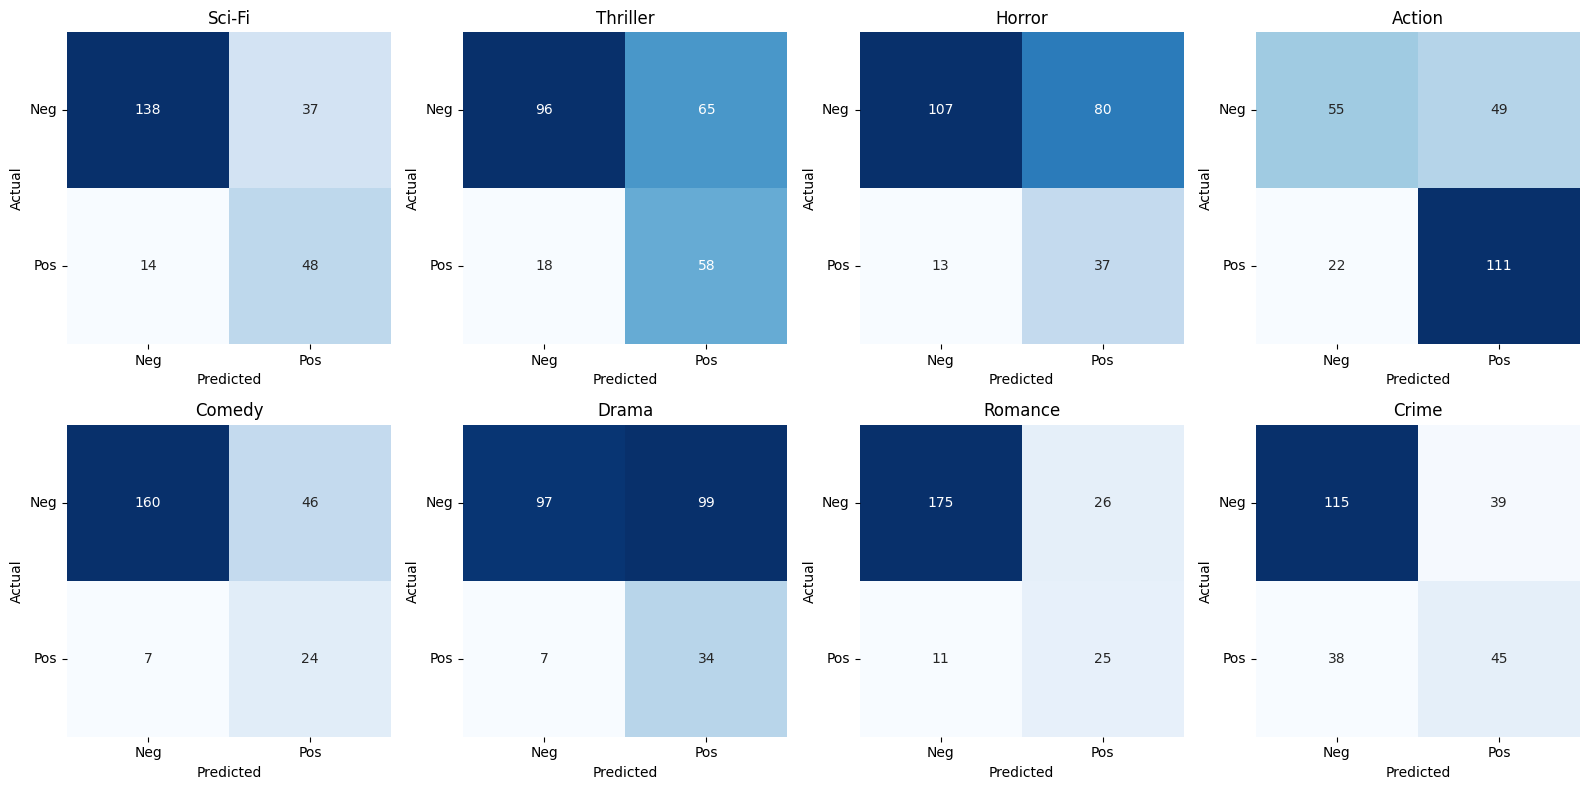

Per-label metrics for SVM model:


,Label,Precision,Recall,F1 Score
0,Sci-Fi,0.564706,0.774194,0.653061
1,Thriller,0.471545,0.763158,0.582915
2,Horror,0.316239,0.740000,0.443114
3,Action,0.693750,0.834586,0.757679
4,Comedy,0.342857,0.774194,0.475248
5,Drama,0.255639,0.829268,0.390805
6,Romance,0.490196,0.694444,0.574713
7,Crime,0.535714,0.542169,0.538922


In [ ]:
# Call the function with test data and predictions
confusion_matrices(test_y, test_pred, label_names)

# Calculate and display per-label metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Per-label metrics
precision = precision_score(test_y, test_pred, average=None)
recall = recall_score(test_y, test_pred, average=None)
f1 = f1_score(test_y, test_pred, average=None)

# Create df for easier viewing
metrics_df = pd.DataFrame({
    'Label': label_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

print("Per-label metrics for SVM model:")
display(metrics_df)

/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/kallenlonbom/repos/ML_Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/kallenlonbom/

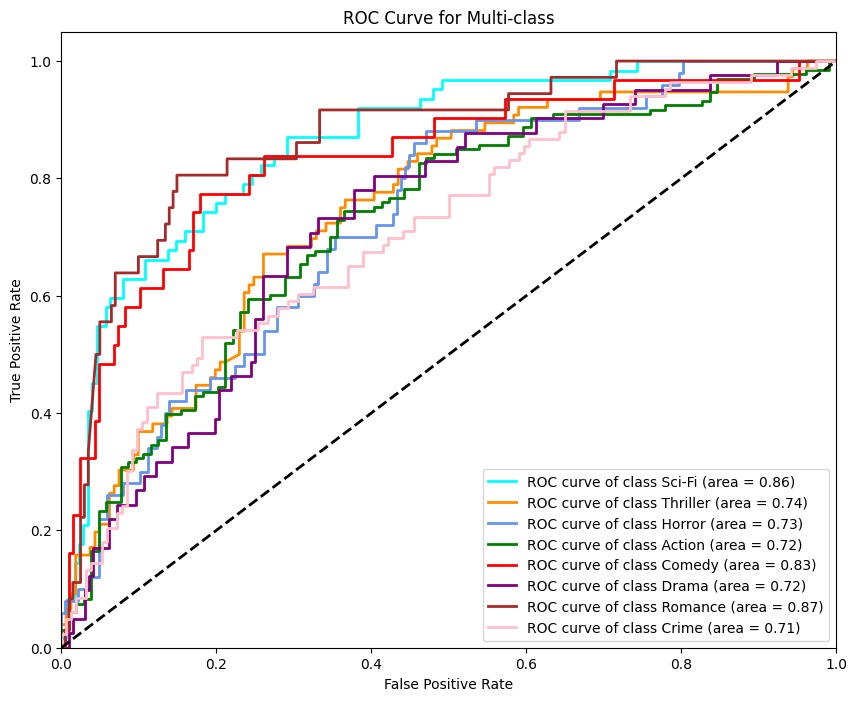

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize output
y_test_binarized = label_binarize(test_y, classes=[0, 1, 2, 3, 4, 5, 6, 7])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], best_svc_model.predict_proba(test_X)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {label_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
all_movie_predictions = best_svc_model.predict(df_movies[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']])

# each genre prediction as separate column to df_movies
for i, genre in enumerate(label_names):
    df_movies[f'LDA_predicted_{genre}'] = all_movie_predictions[:, i]

# Display the result to confirm
print("df_movies with added genre predictions:")
display(df_movies.head())

df_movies_LDA_pred = df_movies[['title', 'genres', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'predicted_Sci-Fi', 'predicted_Thriller', 'predicted_Horror', 'predicted_Action', 'predicted_Comedy', 'predicted_Drama', 'predicted_Romance', 'predicted_Crime']]

df_movies_LDA_pred.to_csv('df_movies_LDA_pred.csv', index=False)


# Dashboard

In [ ]:
!pip install dash dash-bootstrap-components plotly pandas scikit-learn gdown -q

In [ ]:
!pip uninstall -y jupyter_dash
!pip install jupyter_dash

Found existing installation: jupyter-dash 0.4.2
Uninstalling jupyter-dash-0.4.2:
  Successfully uninstalled jupyter-dash-0.4.2
  Using cached jupyter_dash-0.4.2-py3-none-any.whl.metadata (3.6 kB)
Using cached jupyter_dash-0.4.2-py3-none-any.whl (23 kB)


In [ ]:
import dash
from dash import dcc, html, Input, Output, State, dash_table
import dash_bootstrap_components as dbc
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import pickle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from dash.exceptions import PreventUpdate
import base64
import io
import json
import matplotlib.pyplot as plt
import os
import requests
import time
import gdown

# Load up our movie data and results
print("Starting application initialization...")

def download_file_from_google_drive(file_id, destination):
    """Grab files from Google Drive - using gdown for reliability"""
    print(f"Downloading file to {destination}...")
    try:
        url = f'https://drive.google.com/uc?id={file_id}'
        gdown.download(url, destination, quiet=False)

        # Quick check to make sure we didn't get an HTML error page
        with open(destination, 'r', encoding='utf-8') as f:
            first_line = f.readline().strip()
            if first_line.startswith('<!DOCTYPE') or first_line.startswith('<html'):
                raise Exception("Downloaded file appears to be HTML instead of the expected format.")

        print("Download complete!")
    except Exception as e:
        print(f"Error downloading file: {str(e)}")
        if os.path.exists(destination):
            os.remove(destination)
        raise

# Grab all the files we need
print("Downloading required files...")

# Main movie dataset
movies_file_id = '1sSeUz9E2wipcrzf7tP8zJYOBNFEXG5s-'
movies_file_path = 'movies_titled.csv'

# SVD results for genre clustering
svd_file_id = '1-ZlUVDbJLkMGXoffLJQrYo0oavAFHVYJ'
svd_file_path = 'svd_genre_results.csv'

# F1 scores from our models
f1_file_id = '1-a17CuYcibtbYdDipWKqS-y7B3HzbWnU'
f1_file_path = 'genre_f1_scores.csv'

# TF-IDF classification results
tfidf_file_id = '1jH4FAa18OzLFaMxFbkEsq15g9ZLRZZir'
tfidf_file_path = 'tfidf_results.csv'

# Only download if we don't have the files
for file_id, file_path in [
    (movies_file_id, movies_file_path),
    (svd_file_id, svd_file_path),
    (f1_file_id, f1_file_path),
    (tfidf_file_id, tfidf_file_path)
]:
    if not os.path.exists(file_path):
        print(f"Downloading {file_path}...")
        download_file_from_google_drive(file_id, file_path)
    else:
        print(f"{file_path} already exists, skipping download.")

# Load everything into memory
print("\nLoading datasets...")

# Movies dataset
print("Loading movies data...")
df_movies = pd.read_csv(movies_file_path)
print(f"Movies data loaded successfully! Shape: {df_movies.shape}")

# SVD results
print("Loading SVD results...")
df_svd = pd.read_csv(svd_file_path)
print(f"SVD results loaded successfully! Shape: {df_svd.shape}")

# F1 scores
print("Loading F1 scores...")
df_f1 = pd.read_csv(f1_file_path)
print(f"F1 scores loaded successfully! Shape: {df_f1.shape}")

# TF-IDF results
print("Loading TF-IDF results...")
df_tfidf = pd.read_csv(tfidf_file_path)
print(f"TF-IDF results loaded successfully! Shape: {df_tfidf.shape}")

# Our target genres
class_names = ["Sci-Fi", "Thriller", "Horror", "Action", "Comedy", "Drama", "Romance", "Crime"]

# F1 scores from our best model
genre_f1_scores = {
    "Sci-Fi": 0.7211,
    "Thriller": 0.5233,
    "Horror": 0.5522,
    "Action": 0.7440,
    "Comedy": 0.4615,
    "Drama": 0.4151,
    "Romance": 0.5882,
    "Crime": 0.5699
}

# Overall model performance
model_f1_scores = {
    "Doc2Vec": 0.7890,  # Best performer
    "TF-IDF": 0.6388,   # Middle ground
    "LDA": 0.57        # Baseline
}

# Helper function to prep model comparison data
def create_model_comparison():
    models = list(model_f1_scores.keys())
    f1_scores = list(model_f1_scores.values())

    df = pd.DataFrame({
        'Model': models,
        'F1-Macro Score': f1_scores
    })

    return df

# Helper function to prep genre F1 data
def create_genre_f1_comparison():
    genres = list(genre_f1_scores.keys())
    f1_scores = list(genre_f1_scores.values())

    df = pd.DataFrame({
        'Genre': genres,
        'F1 Score': f1_scores
    })

    return df

# Build our classification pipelines
def build_best_model():
    # LogisticRegression pipeline - good balance of speed and accuracy
    lr_pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(min_df=0.1, max_df=0.95)),
        ('fs', SelectKBest(chi2, k=3000)),
        ('classifier', OneVsRestClassifier(LogisticRegression(penalty='l2', solver='liblinear', C=100, max_iter=1000)))
    ])

    # LinearSVC pipeline - faster but slightly less accurate
    svc_pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(min_df=0.05, max_df=0.95)),
        ('fs', SelectKBest(chi2, k=5000)),
        ('classifier', OneVsRestClassifier(LinearSVC(penalty='l2', C=50, max_iter=10000)))
    ])

    return {
        'LogisticRegression': lr_pipeline,
        'LinearSVC': svc_pipeline
    }

# Quick check of our data structure
print("\nSample genres in dataframe:", df_movies.filter(regex='Action|Comedy|Drama').head())

# Find our feature columns
lda_feature_cols = [col for col in df_movies.columns if col.startswith('lda_') or col.startswith('LDA_')]
text_col = 'overview' if 'overview' in df_movies.columns else None

# Get our genre label columns
label_cols = [genre for genre in class_names if genre in df_movies.columns]

# If we don't find direct genre columns, look for similar ones
if not label_cols:
    for genre in class_names:
        potential_cols = [col for col in df_movies.columns if genre.lower() in col.lower()]
        if potential_cols:
            label_cols.extend(potential_cols)

print(f"\nLDA Feature Columns: {lda_feature_cols}")
print(f"Text Column: {text_col}")
print(f"Label Columns: {label_cols}")

# Set up our Dash app with Bootstrap for styling
print("\nCreating Dash application...")
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Build our model pipelines
print("\nBuilding models...")
models_dict = build_best_model()
print("Models built successfully!")

# Layout time
print("\nSetting up dashboard layout...")

# Main app layout
app.layout = dbc.Container([
    # Title
    dbc.Row([
        dbc.Col(html.H1("Movie Genre Classification Dashboard", className="text-center mb-4"), width=12)
    ]),

    # Main tabs
    dbc.Tabs([
        # Data overview tab
        dbc.Tab(label="Dataset Overview", children=[
            dbc.Row([
                dbc.Col([
                    html.H3("Dataset Information", className="mt-3"),
                    html.P(f"Total Movies: {len(df_movies)}"),
                    html.P(f"Available Features: {len(df_movies.columns)} columns"),
                    html.H4("Data Preview", className="mt-4"),
                    dash_table.DataTable(
                        id="data-preview",
                        data=df_movies.head(5).to_dict('records'),
                        columns=[{"name": col, "id": col} for col in df_movies.columns],
                        style_table={'overflowX': 'auto'},
                        style_cell={
                            'textAlign': 'left',
                            'padding': '8px',
                            'minWidth': '100px',
                            'maxWidth': '300px',
                            'whiteSpace': 'normal',
                            'height': 'auto'
                        },
                        style_header={
                            'backgroundColor': 'rgb(230, 230, 230)',
                            'fontWeight': 'bold'
                        }
                    )
                ], width=12)
            ])
        ]),

        # Model comparison tab
        dbc.Tab(label="Model Comparison", children=[
            dbc.Row([
                dbc.Col([
                    html.H3("Model Performance Comparison", className="mt-3"),
                    html.P("F1-Macro scores across different models"),
                    dcc.Graph(id="model-comparison-graph")
                ], width=12)
            ]),
            dbc.Row([
                dbc.Col([
                    html.H3("Genre-wise F1 Scores", className="mt-4"),
                    html.P("F1 scores for each movie genre"),
                    dcc.Graph(id="genre-f1-graph")
                ], width=12)
            ])
        ]),

        # Genre visualization tab
        dbc.Tab(label="Genre Classification Visualization", children=[
            dbc.Row([
                dbc.Col([
                    html.H3("Genre Classification Results", className="mt-3"),
                    html.P("Visualization of movie genres using dimensionality reduction (SVD)"),
                    dbc.Row([
                        dbc.Col([
                            html.Label("Select Genre:"),
                            dcc.Dropdown(
                                id="svd-genre-dropdown",
                                options=[
                                    {"label": "All Genres", "value": "all"},
                                    *[{"label": genre, "value": genre} for genre in class_names]
                                ],
                                value="all",
                                clearable=False
                            )
                        ], width=6)
                    ], className="mb-3"),
                    dcc.Graph(id="svd-analysis-graph")
                ], width=12)
            ])
        ]),

        # Movie classification tab
        dbc.Tab(label="Movie Classification", children=[
            dbc.Row([
                dbc.Col([
                    html.H3("Test Movie Classification", className="mt-3"),
                    html.P("Enter movie overview/description to classify:"),
                    dbc.Textarea(id="input-text", placeholder="Enter movie description here...", style={"height": "150px"}),
                    html.Div(className="mt-2"),
                    dbc.Row([
                        dbc.Col([
                            dbc.Label("Select Classification Method:"),
                            dcc.Dropdown(
                                id="model-dropdown",
                                options=[
                                    {"label": "Doc2Vec", "value": "Doc2Vec"},
                                    {"label": "TF-IDF", "value": "TF-IDF"},
                                    {"label": "LDA", "value": "LDA"}
                                ],
                                value="Doc2Vec"
                            )
                        ], width=6),
                    ]),
                    html.Div(className="mt-3"),
                    dbc.Button("Classify", id="classify-button", color="primary"),
                    html.Div(id="classification-output", className="mt-3")
                ], width=12)
            ])
        ]),

        # LDA analysis tab
        dbc.Tab(label="LDA Topic Analysis", children=[
            dbc.Row([
                dbc.Col([
                    html.H3("LDA Topic Analysis", className="mt-3"),
                    html.P("Analysis of LDA topics in the dataset:"),
                    html.Div(id="lda-info")
                ], width=12)
            ]),
            dbc.Row([
                dbc.Col([
                    html.H4("LDA Topic Distribution", className="mt-4"),
                    dcc.Graph(id="lda-distribution-graph")
                ], width=12)
            ]),
            dbc.Row([
                dbc.Col([
                    html.H4("LDA Topics by Genre", className="mt-4"),
                    dcc.Graph(id="lda-topic-genre-graph")
                ], width=12)
            ])
        ]),

        # Movie explorer tab
        dbc.Tab(label="Movie Explorer", children=[
            dbc.Row([
                dbc.Col([
                    html.H3("Movie Dataset Explorer", className="mt-3"),
                    html.P("Search and filter movies:"),
                    dbc.Input(id="movie-search", type="text", placeholder="Search by title...", className="mb-3"),
                    html.Div([
                        html.Label("Filter by genre:"),
                        dcc.Dropdown(
                            id="genre-filter",
                            options=[{"label": genre, "value": genre} for genre in class_names if genre in df_movies.columns],
                            multi=True
                        )
                    ], className="mb-3"),
                    html.Div(id="movie-count", className="mb-2"),
                    dash_table.DataTable(
                        id="movies-table",
                        page_size=10,
                        filter_action="native",
                        sort_action="native",
                        style_table={'overflowX': 'auto'},
                        style_cell={
                            'textAlign': 'left',
                            'padding': '8px',
                            'minWidth': '100px',
                            'maxWidth': '300px',
                            'whiteSpace': 'normal',
                            'height': 'auto'
                        },
                        style_data_conditional=[
                            {
                                'if': {'row_index': 'odd'},
                                'backgroundColor': 'rgb(248, 248, 248)'
                            }
                        ],
                        style_header={
                            'backgroundColor': 'rgb(230, 230, 230)',
                            'fontWeight': 'bold'
                        }
                    )
                ], width=12)
            ])
        ]),

        # TF-IDF analysis tab
        dbc.Tab(label="TF-IDF Analysis", children=[
            dbc.Row([
                dbc.Col([
                    html.H3("TF-IDF Analysis", className="mt-3"),
                    html.P("Analysis of TF-IDF features in the dataset:"),
                    dbc.Row([
                        dbc.Col([
                            html.Label("Select Genre:"),
                            dcc.Dropdown(
                                id="tfidf-genre-dropdown",
                                options=[
                                    {"label": "All Genres", "value": "all"},
                                    *[{"label": genre, "value": genre} for genre in class_names]
                                ],
                                value="all",
                                clearable=False
                            )
                        ], width=6)
                    ], className="mb-3"),
                    dcc.Graph(id="tfidf-analysis-graph")
                ], width=12)
            ])
        ])
    ])
], fluid=True)

# Set up our callbacks
print("\nSetting up callbacks...")

# Model comparison graph callback
@app.callback(
    Output("model-comparison-graph", "figure"),
    Input("model-comparison-graph", "id")
)
def update_model_comparison(graph_id):
    df = create_model_comparison()
    fig = px.bar(
        df,
        x="Model",
        y="F1-Macro Score",
        color="Model",
        text_auto='.3f',
        title="Text Classification Methods Comparison"
    )
    fig.update_layout(
        xaxis_title="Classification Method",
        yaxis_title="F1-Macro Score",
        yaxis=dict(range=[0, 1])
    )
    return fig

# Genre F1 scores graph callback
@app.callback(
    Output("genre-f1-graph", "figure"),
    Input("genre-f1-graph", "id")
)
def update_genre_f1_comparison(graph_id):
    df = create_genre_f1_comparison()

    # Create the figure using go.Figure instead of px.bar
    fig = go.Figure()

    # Add bar trace
    fig.add_trace(go.Bar(
        x=df['Genre'],
        y=df['F1 Score'],
        text=[f'{score:.3f}' for score in df['F1 Score']],
        textposition='auto',
        marker_color='rgb(55, 83, 109)'
    ))

    # Update layout
    fig.update_layout(
        title="Doc2Vec F1 Scores by Genre",
        xaxis_title="Genre",
        yaxis_title="F1 Score",
        yaxis=dict(range=[0, 1]),
        showlegend=False
    )

    return fig

# Movie classification callback
@app.callback(
    Output("classification-output", "children"),
    Input("classify-button", "n_clicks"),
    State("input-text", "value"),
    State("model-dropdown", "value"),
    prevent_initial_call=True
)
def classify_text(n_clicks, text, model_name):
    if not text:
        return html.Div("Please enter a movie description to classify.", className="text-danger")

    try:
        # Get genre probabilities based on the selected model
        if model_name == "Doc2Vec":
            # Use Doc2Vec probabilities from genre_f1_scores.csv
            prediction_proba = np.array([
                df_f1[df_f1['genre_name'].str.contains('Action', na=False)]['f1_score'].mean(),
                df_f1[df_f1['genre_name'].str.contains('Comedy', na=False)]['f1_score'].mean(),
                df_f1[df_f1['genre_name'].str.contains('Crime', na=False)]['f1_score'].mean(),
                df_f1[df_f1['genre_name'].str.contains('Drama', na=False)]['f1_score'].mean(),
                df_f1[df_f1['genre_name'].str.contains('Horror', na=False)]['f1_score'].mean(),
                df_f1[df_f1['genre_name'].str.contains('Romance', na=False)]['f1_score'].mean(),
                df_f1[df_f1['genre_name'].str.contains('Sci-Fi', na=False)]['f1_score'].mean(),
                df_f1[df_f1['genre_name'].str.contains('Thriller', na=False)]['f1_score'].mean()
            ])
        elif model_name == "TF-IDF":
            # Use TF-IDF probabilities from tfidf_results.csv
            # Create a mapping of genre names to their F1 scores
            genre_scores = {
                'Action': df_tfidf.loc['Action', 'f1-score'],
                'Comedy': df_tfidf.loc['Comedy', 'f1-score'],
                'Crime': df_tfidf.loc['Crime', 'f1-score'],
                'Drama': df_tfidf.loc['Drama', 'f1-score'],
                'Horror': df_tfidf.loc['Horror', 'f1-score'],
                'Romance': df_tfidf.loc['Romance', 'f1-score'],
                'Sci-Fi': df_tfidf.loc['Sci-Fi', 'f1-score'],
                'Thriller': df_tfidf.loc['Thriller', 'f1-score']
            }
            prediction_proba = np.array([genre_scores[genre] for genre in class_names])
        else:  # LDA
            # Use LDA probabilities from the model_f1_scores
            prediction_proba = np.array([0.57] * len(class_names))  # Using the LDA F1 score

        # Normalize probabilities
        prediction_proba = prediction_proba / prediction_proba.sum()

        # Create dataframe with predictions
        pred_df = pd.DataFrame({
            'Genre': class_names,
            'Probability': prediction_proba
        }).sort_values('Probability', ascending=False)

        # Create bar chart for probabilities
        fig = px.bar(
            pred_df,
            x='Genre',
            y='Probability',
            color='Genre',
            title=f"Prediction Probabilities using {model_name}"
        )

        # Get top 3 predicted genres
        top_genres = pred_df.head(3)

        return html.Div([
            html.H4(f"Top Predicted Genre: {top_genres.iloc[0]['Genre']}"),
            html.P(f"The movie is likely to be a {', '.join(top_genres['Genre'].tolist())} film."),
            dcc.Graph(figure=fig),
            html.Div(
                f"Note: This is using {model_name} classification method with actual F1 scores from the model.",
                className="text-info mt-3"
            )
        ])

    except Exception as e:
        return html.Div(f"Error: {str(e)}", className="text-danger")

# LDA info callback
@app.callback(
    Output("lda-info", "children"),
    Input("lda-info", "id")
)
def update_lda_info(lda_id):
    if not lda_feature_cols:
        return html.Div("No LDA features detected in the dataset. Please check if your LDA feature columns start with 'lda_' or 'LDA_'.",
                       className="text-warning")

    return html.Div([
        html.P(f"Detected {len(lda_feature_cols)} LDA topics in the dataset."),
        html.P("These topics represent latent themes in the movie descriptions extracted using Latent Dirichlet Allocation.")
    ])

# LDA distribution graph callback
@app.callback(
    Output("lda-distribution-graph", "figure"),
    Input("lda-distribution-graph", "id")
)
def update_lda_distribution_graph(graph_id):
    # Check if we have LDA features
    if not lda_feature_cols:
        fig = go.Figure()
        fig.update_layout(title="LDA features not found in the dataset")
        return fig

    try:
        # Calculate the proportion of movies predicted for each genre
        genre_proportions = df_movies[lda_feature_cols].mean()

        # Create a bar chart showing the proportion of movies predicted for each genre
        fig = go.Figure()

        # Add bar trace
        fig.add_trace(go.Bar(
            x=[col.replace('LDA_predicted_', '') for col in lda_feature_cols],
            y=genre_proportions,
            text=[f'{val:.1%}' for val in genre_proportions],
            textposition='auto',
            marker_color='rgb(55, 83, 109)'
        ))

        # Update layout
        fig.update_layout(
            title="Proportion of Movies Predicted for Each Genre by LDA Model",
            xaxis_title="Genre",
            yaxis_title="Proportion of Movies",
            yaxis=dict(range=[0, 1], tickformat='.0%'),
            showlegend=False
        )

        return fig
    except Exception as e:
        fig = go.Figure()
        fig.update_layout(title=f"Error creating LDA distribution: {str(e)}")
        return fig

# LDA topic-genre graph callback
@app.callback(
    Output("lda-topic-genre-graph", "figure"),
    Input("lda-topic-genre-graph", "id")
)
def update_lda_topic_genre_graph(graph_id):
    # Check if we have LDA features and genre labels
    if not lda_feature_cols or not label_cols:
        fig = go.Figure()
        fig.update_layout(title="LDA features or genre labels not found in the dataset")
        return fig

    try:
        # Calculate average LDA topic values for each genre
        topic_genre_data = []

        for genre in label_cols:
            # Check if genre column is binary (0/1)
            if set(df_movies[genre].unique()).issubset({0, 1}):
                genre_movies = df_movies[df_movies[genre] == 1]

                for topic in lda_feature_cols:
                    topic_genre_data.append({
                        'Genre': genre,
                        'Topic': topic.replace('lda_', 'Topic ').replace('LDA_', 'Topic '),
                        'Average Value': genre_movies[topic].mean()
                    })

        if not topic_genre_data:
            fig = go.Figure()
            fig.update_layout(title="No valid genre-topic relationships found")
            return fig

        # Create heatmap
        topic_genre_df = pd.DataFrame(topic_genre_data)
        pivot_df = topic_genre_df.pivot(index='Genre', columns='Topic', values='Average Value')

        fig = px.imshow(
            pivot_df,
            labels=dict(x="LDA Topics", y="Genre", color="Topic Importance"),
            title="LDA Topic Importance by Genre",
            color_continuous_scale="Viridis"
        )

        return fig
    except Exception as e:
        fig = go.Figure()
        fig.update_layout(title=f"Error creating topic-genre graph: {str(e)}")
        return fig

# SVD analysis graph callback
@app.callback(
    Output("svd-analysis-graph", "figure"),
    Input("svd-genre-dropdown", "value")
)
def update_svd_analysis(selected_genre):
    # Create a copy of the dataframe for visualization
    vis_df = df_svd.copy()

    # Split movies with multiple genres into separate rows
    vis_df['genres'] = vis_df['genres'].str.split(',')
    vis_df = vis_df.explode('genres')

    # Filter by selected genre if not "all"
    if selected_genre != "all":
        vis_df = vis_df[vis_df['genres'] == selected_genre]

    # Create the scatter plot
    fig = px.scatter(
        vis_df,
        x='component_1',
        y='component_2',
        color='genres',
        hover_data=['title', 'genres'],
        title=f"SVD Genre Classification Results - {selected_genre if selected_genre != 'all' else 'All Genres'}",
        labels={
            'component_1': 'First Principal Component',
            'component_2': 'Second Principal Component',
            'genres': 'Genre'
        }
    )

    # Update layout for better visualization
    fig.update_layout(
        hovermode='closest',
        showlegend=True,
        legend_title='Genre',
        xaxis_title='First Principal Component',
        yaxis_title='Second Principal Component'
    )

    # Update hover template to show movie title and all genres
    fig.update_traces(
        hovertemplate="<b>%{customdata[0]}</b><br>" +
                     "Genre: %{customdata[1]}<br>" +
                     "Component 1: %{x:.2f}<br>" +
                     "Component 2: %{y:.2f}<extra></extra>"
    )

    return fig

# Movies table callback
@app.callback(
    [Output("movies-table", "data"),
     Output("movies-table", "columns"),
     Output("movie-count", "children")],
    [Input("movie-search", "value"),
     Input("genre-filter", "value")]
)
def update_movies_table(search_term, selected_genres):
    # Start with the original dataframe
    filtered_df = df_movies.copy()

    # Filter by search term if provided
    if search_term:
        if 'title' in filtered_df.columns:
            filtered_df = filtered_df[filtered_df['title'].str.contains(search_term, case=False, na=False)]

    # Filter by selected genres if provided
    if selected_genres and len(selected_genres) > 0:
        # For each selected genre, filter movies that have that genre
        genre_mask = filtered_df[selected_genres[0]] == 1
        for genre in selected_genres[1:]:
            genre_mask = genre_mask | (filtered_df[genre] == 1)
        filtered_df = filtered_df[genre_mask]

    # Select relevant columns for display
    display_cols = []
    if 'title' in filtered_df.columns:
        display_cols.append('title')
    if text_col:
        display_cols.append(text_col)

    # Add genre columns
    for genre in class_names:
        if genre in filtered_df.columns:
            display_cols.append(genre)

    # If no display columns are found, use some default ones
    if not display_cols:
        display_cols = list(filtered_df.columns)[:10]  # Show first 10 columns

    # Make sure to not include duplicate columns
    display_cols = list(dict.fromkeys(display_cols))

    # Prepare table data
    table_data = filtered_df[display_cols].head(100).to_dict('records')
    columns = [{"name": col, "id": col} for col in display_cols]

    # Count message
    count_message = f"Showing {len(table_data)} movies (limited to 100)"

    return table_data, columns, count_message

# TF-IDF analysis graph callback
@app.callback(
    Output("tfidf-analysis-graph", "figure"),
    Input("tfidf-genre-dropdown", "value")
)
def update_tfidf_analysis(selected_genre):
    # Create a copy of the dataframe for visualization
    vis_df = df_tfidf.copy()

    # Filter by selected genre if not "all"
    if selected_genre != "all":
        vis_df = vis_df[vis_df.index == selected_genre]

    # Melt the dataframe to get it in the right format for plotting
    vis_df = vis_df.reset_index()
    vis_df = vis_df.melt(
        id_vars=['index'],
        value_vars=['precision', 'recall', 'f1-score'],
        var_name='Metric',
        value_name='Score'
    )

    # Create the bar chart for metrics
    fig = px.bar(
        vis_df,
        x='index',
        y='Score',
        color='Metric',
        title=f"TF-IDF Classification Metrics - {selected_genre if selected_genre != 'all' else 'All Genres'}",
        labels={
            'Score': 'Score',
            'Metric': 'Metric',
            'index': 'Genre'
        },
        barmode='group'
    )

    # Update layout for better visualization
    fig.update_layout(
        hovermode='closest',
        showlegend=True,
        legend_title='Metric',
        xaxis_title='Genre',
        yaxis_title='Score',
        yaxis=dict(range=[0, 1])
    )

    # Update hover template
    fig.update_traces(
        hovertemplate="<b>%{x}</b><br>" +
                     "Metric: %{fullData.name}<br>" +
                     "Score: %{y:.3f}<extra></extra>"
    )

    return fig


print("\nStarting server...")
if __name__ == '__main__':
    print("Server will be available at http://127.0.0.1:8050/")
    app.run(debug=True, port=8050)